This notebook consists of following sections:

a. Imported libraries and checking on GPU

b. Customized Functions or/and Classes

c. Main Body

# Importing libraries and checking on GPU

In [2]:
!pip install hdf5storage
!pip install keras-tuner
!pip install xgboost
!pip install scikit-learn

# from google.colab import drive
# from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from kerastuner.tuners import RandomSearch
from keras.models import *
from keras.layers import *
from keras.callbacks import EarlyStopping
import xgboost as xgb
import tensorflow as tf
import seaborn as sns
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import joblib
import hdf5storage
import datetime
import random

pd.options.display.max_columns = None  # To display all columns in pandas

# These options determine the way floating point numbers are displayed.
np.set_printoptions(precision=4, suppress=True)

# I use Google Colab, this is to mound the drive

# drive.mount('/drive')

os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(100)


def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


set_seeds()


In [3]:
# Checking if GPU available in our system

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [ ]:
# Compare if the GPU is faster than CPU in the system, the perform
# operation with GPU for specific code
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')


def cpu():
    with tf.device('/cpu:0'):
        random_image_cpu = tf.random.normal((100, 100, 100, 3))
        net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
        return tf.math.reduce_sum(net_cpu)


def gpu():
    with tf.device('/device:GPU:0'):
        random_image_gpu = tf.random.normal((100, 100, 100, 3))
        net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
        return tf.math.reduce_sum(net_gpu)


# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time / gpu_time)))

2023-05-20 20:18:23.584005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-20 20:18:23.584079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-20 20:18:23.586578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-20 20:18:23.586604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Customized Functions or/and Classes

In [7]:
# Exception to handle NaN values

class NaNDataException(Exception):
    def __init__(self, message="NaN values encountered"):
        self.message = message
        super().__init__(self.message)

def data_has_nan(data):
    # Check if data contains NaN values and return True or False
    return np.isnan(data).any()

In [8]:
def xgboost_cross_validation(features, label):
    """
    Do the 10-folds cross validation test with XGBoost.

    Input:
      feature_matrix (DataFrame): The raw data of the stock.

    Output:
      all_rmse (list): The list of RMSE for all folds.
    """
    if data_has_nan(features):
        raise NaNDataException("NaN values are present in the provided dataset")
    else:
        pass

    scaler = MinMaxScaler()
    features_scaled = pd.DataFrame(scaler.fit_transform(features))

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=10)
    print(tscv)
    print(62 * '#')

    # Set a list to save the rmse for all folds
    all_rmse = []
    counter = 0

    for train_index, test_index in tscv.split(features):

        counter += 1
        print('Fold %d:' % counter)

        print("TRAIN:", len(train_index), "TEST:", len(test_index))

        X_train, X_test = features.iloc[train_index,
                                        :], features.iloc[test_index, :]
        y_train, y_test = label.iloc[train_index], label.iloc[test_index]
        print(70 * '-')

        # Build the model
        model = XGBRegressor(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.1,
            random_state=42)

        # Fit model with history to check for overfitting
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        Y_test_numpy = np.array(y_test)

        rmse = mean_squared_error(Y_test_numpy, y_pred, squared=False)

        print('testScore:', rmse)

        all_rmse.append(rmse)

    return all_rmse


In [9]:
# Grid Search CV with Keras
# Define the model architecture
def create_model(num_units=64, dropout_rate=0.2, look_back=60):
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(look_back, X_train_lstm.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def grid_search(X_train, y_train):
    # Set up the hyperparameter search space
    num_units = [32, 64, 128]
    dropout_rates = [0.1, 0.2, 0.3]
    param_grid = dict(num_units=num_units, dropout_rate=dropout_rates)

    # Create the model and the grid search object
    model = KerasRegressor(
        build_fn=create_model,
        epochs=10,
        batch_size=32,
        verbose=0)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

    # Fit the grid search object to the data
    grid_result = grid.fit(X_train, y_train)

    # Print the best parameters and the corresponding mean squared error score
    print("Best Parameters: ", grid_result.best_params_)
    print("Best Score: ", np.abs(grid_result.best_score_))

In [54]:
def process_lstm_data(data, look_back=60, horizon=1, jump=1):
    """
    Split the data into X and Y and do data pre-processing for LSTM.

    Input:
        data(NumPy array): The full dataset.
        look_back(int): The number of historical events for LSTM to memorise.
        horizon(int): The number of future LSTM should predict at one time.
        jump(int): The next period we want to predict after each LSTM window.

    Output:
        X(NumPy array): Features in format that is suitable for LSTM.
        Y(NumPy array): Label in format that is suitable for LSTM.
    """

    X, Y = [], []

    for i in range(0, len(data) - look_back - horizon + 1, jump):
        # X contains all columns except the label
        X.append(data[i:(i + look_back), :-1])

        # Y only contains the mid-price (label)
        Y.append(data[(i + look_back - 1):(i + look_back + horizon - 1), -1])

    X = np.array(X)
    Y = np.array(Y)

    return X, Y


In [10]:
def normalise_data(array_raw):
    """
    Normalise the array.
    """
    scaler = MinMaxScaler()
    array = scaler.fit_transform(array_raw)
    return array, scaler


def inverse_predictions(predictions, scaler, prediction_index=-1):
    '''
    This function uses the fitted scaler to inverse predictions,
    the index should be set to the position of the target variable,
    in this case, the last column (mid price column).
    This will be used for the label inverse prediction.
    '''
    max_val = scaler.data_max_[prediction_index]
    min_val = scaler.data_min_[prediction_index]
    original_values = (predictions * (max_val - min_val)) + min_val
    return original_values


In [56]:
def build_lstm(look_back, horizon, X_train, y_train, X_validate, y_validate, i):
    """
    Build and train the the LSTM regression model.

    Input:
      X_train (NumPy array): Training features
      y_train (NumPy array): Training label
      X_validate (NumPy array): Validation features
      y_validate (NumPy array): Validation label
      i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
      model (Keras `Sequential`): Trained regression model with LSTM layer
      history (`tf.keras.callbacks.History`): History of model training
    """
    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fitting the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    if i != 0:
        model.load_weights(
            '/drive/My Drive/Colab Notebooks/FML 2/model_weights.h5')

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(
            X_validate,
            y_validate),
        shuffle=False,
        batch_size=16,
        verbose=1,
        callbacks=[early_stopping])

    return model, history


In [57]:
def lstm(X_train, X_validate, X_test, y_train, y_validate, y_test, i):
    """
    Predict the mid price using vanilla LSTM regressor.

    Input:
      X_train (NumPy array): Training features
      X_validate (NumPy array): Validation features
      X_test (NumPy array): Test features
      y_train (NumPy array): Training label
      y_validate (NumPy array): Validation label
      y_test (NumPy array): Test label
      i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
      rmse (float): The RMSE score from prediction versus y_test
    """
    look_back = 60
    horizon = 1

    # Build the LSTM model
    model, history = build_lstm(
        look_back, horizon, X_train, y_train, X_validate, y_validate, i)
    model.save_weights('/drive/My Drive/Colab Notebooks/FML 2/model_weights.h5')

    # Showing the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    plt.show()

    # Predict
    y_pred_test = model.predict(X_test)

    # Get the original values for mid_price prediction
    y_pred = []
    for i in range(len(y_pred_test)):
        inverse = inverse_predictions(y_pred_test[i], scaler, -1)
        y_pred.append(inverse)
    y_pred = np.array(y_pred)
    # print(y_pred)

    # Get the original values for mid_price in test set
    y_test_inverse = []
    for i in range(len(y_test)):
        inverse = inverse_predictions(y_test[i], scaler, -1)
        y_test_inverse.append(inverse)
    y_test_inverse = np.array(y_test_inverse)

    # Showing prediction vs target
    plt.figure(figsize=(10, 6))
    plt.plot(y_pred.reshape(-1, 1), color='r', label='Prediction')
    plt.plot(y_test_inverse.reshape(-1, 1), label='Target')
    plt.legend(loc='best')
    plt.show()

    # Calculating RMSE
    rmse = mean_squared_error(y_test_inverse, y_pred, squared=False)

    print(f"RMSE LSTM: {rmse}")

    return rmse


In [69]:
def build_lstm_51(look_back, horizon, X_train, y_train, X_validate, y_validate,
                  i):
    """
    Build and train the the LSTM regression model.
    11 features are added to this model, make a total of 51 features.

    Input:
      X_train (NumPy array): Training features
      y_train (NumPy array): Training label
      X_validate (NumPy array): Validation features
      y_validate (NumPy array): Validation label
      i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
      model (Keras `Sequential`): Trained regression model with LSTM layer
      history (`tf.keras.callbacks.History`): History of model training
    """
    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fitting the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    if i != 0:
        model.load_weights(
            '/drive/My Drive/Colab Notebooks/FML 2/mdl_weights51.h5')

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(
            X_validate,
            y_validate),
        shuffle=False,
        batch_size=16,
        verbose=1,
        callbacks=[early_stopping])

    return model, history


In [70]:
def lstm_51(X_train, X_validate, X_test, y_train, y_validate, y_test, i):
    """
    Predict the mid price using vanilla LSTM regressor.
    11 features are added to this model, make a total of 51 features.

    Input:
      X_train (NumPy array): Training features
      X_validate (NumPy array): Validation features
      X_test (NumPy array): Test features
      y_train (NumPy array): Training label
      y_validate (NumPy array): Validation label
      y_test (NumPy array): Test label
      i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
      rmse (float): The RMSE score from prediction versus y_test
    """
    look_back = 60
    horizon = 1

    # Build the LSTM model
    model, history = build_lstm_51(
        look_back, horizon, X_train, y_train, X_validate, y_validate, i)
    model.save_weights('/drive/My Drive/Colab Notebooks/FML 2/mdl_weights51.h5')

    # Showing the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    plt.show()

    # Predict
    y_pred_test = model.predict(X_test)

    # Get the original values for mid_price prediction
    y_pred = []
    for i in range(len(y_pred_test)):
        inverse = inverse_predictions(y_pred_test[i], scaler, -1)
        y_pred.append(inverse)
    y_pred = np.array(y_pred)
    # print(y_pred)

    # Get the original values for mid_price in test set
    y_test_inverse = []
    for i in range(len(y_test)):
        inverse = inverse_predictions(y_test[i], scaler, -1)
        y_test_inverse.append(inverse)
    y_test_inverse = np.array(y_test_inverse)

    # Showing prediction vs target
    plt.figure(figsize=(10, 6))
    plt.plot(y_pred.reshape(-1, 1), color='r', label='Prediction')
    plt.plot(y_test_inverse.reshape(-1, 1), label='Target')
    plt.legend(loc='best')
    plt.show()

    # Calculating RMSE
    rmse = mean_squared_error(y_test_inverse, y_pred, squared=False)

    print(f"RMSE LSTM: {rmse}")

    return rmse


In [58]:
def build_lstm_for_ae_plus(
        look_back,
        horizon,
        X_train,
        y_train,
        X_validate,
        y_validate,
        i):
    """
    Build and train the the LSTM regression model.

    Input:
        X_train (NumPy array): Training features
        y_train (NumPy array): Training label
        X_validate (NumPy array): Validation features
        y_validate (NumPy array): Validation label
        i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
        model (Keras `Sequential`): Trained regression model with LSTM layer
        history (`tf.keras.callbacks.History`): History of model training
    """

    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fitting the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    if i != 0:
        model.load_weights(
            '/drive/My Drive/Colab Notebooks/FML 2/model_weights_lstmae_plus.h5'
        )

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(
            X_validate,
            y_validate),
        shuffle=False,
        batch_size=16,
        verbose=1,
        callbacks=[early_stopping])

    return model, history


def lstm_autoencoder_plusfeature(
        X_train,
        X_validate,
        X_test,
        y_train,
        y_validate,
        y_test,
        i,
        latent_dim=20):
    """
    Predict the mid price using LSTM regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        i (int): Iteration number in online learning (i=0 means first iteration)
        latent_dim (int): Number of latent dimension extracted from Autoencoder

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """

    look_back = 60
    horizon = 1
    features = X_train_lstm.shape[2]

    encoder_inputs = Input(shape=(look_back, features))
    encoder = LSTM(latent_dim, return_sequences=True)(encoder_inputs)
    decoder = LSTM(features, return_sequences=True)(encoder)
    decoder_outputs = TimeDistributed(Dense(features))(decoder)

    autoencoder = Model(encoder_inputs, decoder_outputs)
    autoencoder.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(
        monitor='val_loss',
        mode='auto',
        restore_best_weights=True,
        verbose=1,
        patience=10)
    autoencoder.fit(
        X_train,
        X_train,
        epochs=50,
        batch_size=16,
        validation_data=(
            X_validate,
            X_validate),
        callbacks=[es])

    # Use encoder to obtain encoded representation (latent dimension)
    # The combined array consists of 44 features + 20 latent features = 64
    # features
    encoder_model = Model(encoder_inputs, encoder)
    encoded_X_train = encoder_model.predict(X_train)
    combined_X_train_latent = np.concatenate((encoded_X_train, X_train), axis=2)
    encoded_X_test = encoder_model.predict(X_test)
    combined_X_test_latent = np.concatenate((encoded_X_test, X_test), axis=2)
    # print(combined_X_test_latent.shape)

    # Split the training data to 80% training and 20% validation
    X_train, X_validate, y_train, y_validate = train_test_split(
        combined_X_train_latent, y_train, test_size=0.20, random_state=0,
        shuffle=False
    )
    model, history = build_lstm_for_ae_plus(
        look_back, horizon, X_train, y_train, X_validate, y_validate, i)
    model.save_weights(
        '/drive/My Drive/Colab Notebooks/FML 2/model_weights_lstmae_plus.h5')

    # Make predictions on test data
    y_pred = model.predict(combined_X_test_latent)

    y_test_inverse = inverse_predictions(y_test_lstm, scaler, -1)
    y_pred_inverse = inverse_predictions(y_pred, scaler, -1)

    # Calculate the RMSE
    rmse = mean_squared_error(y_test_inverse, y_pred_inverse, squared=False)

    print('RMSE LSTM AE 60 features:', rmse)

    return rmse


In [59]:
def build_lstm_for_ae(
        look_back,
        horizon,
        X_train,
        y_train,
        X_validate,
        y_validate,
        i):
    """
    Predict the mid price using LSTM regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        i (int): Iteration number in online learning (i=0 means first iteration)
        latent_dim (int): Number of latent dimension we want to extract from Autoencoder

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """

    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fitting the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    if i != 0:
        model.load_weights(
            '/drive/My Drive/Colab Notebooks/FML 2/model_weights_lstmae.h5')

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(
            X_validate,
            y_validate),
        shuffle=False,
        batch_size=16,
        verbose=1,
        callbacks=[early_stopping])

    return model, history


def lstm_autoencoder(
        X_train,
        X_validate,
        X_test,
        y_train,
        y_validate,
        y_test,
        i,
        latent_dim=20):
    """
    Predict the mid price using vanilla LSTM regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        i (int): Iteration number in online learning (i=0 means first iteration)
        latent_dim (int): Number of latent dimension we want to extract from Autoencoder

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """
    look_back = 60
    horizon = 1

    encoder_inputs = Input(shape=(look_back, X_train_lstm.shape[2]))
    encoder = LSTM(latent_dim, return_sequences=True)(encoder_inputs)
    decoder = LSTM(X_train_lstm.shape[2], return_sequences=True)(encoder)
    decoder_outputs = TimeDistributed(Dense(X_train_lstm.shape[2]))(decoder)

    autoencoder = Model(encoder_inputs, decoder_outputs)
    autoencoder.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(
        monitor='val_loss',
        mode='auto',
        restore_best_weights=True,
        verbose=1,
        patience=10)
    autoencoder.fit(
        X_train,
        X_train,
        epochs=50,
        batch_size=16,
        validation_data=(
            X_validate,
            X_validate),
        callbacks=[es])

    # Use encoder to obtain encoded representation of input data (latent
    # dimension)
    encoder_model = Model(encoder_inputs, encoder)
    encoded_X_train = encoder_model.predict(X_train)
    encoded_X_test = encoder_model.predict(X_test)

    # Split the training data to 80% training and 20% validation
    X_train, X_validate, y_train, y_validate = train_test_split(
        encoded_X_train, y_train, test_size=0.20, random_state=0, shuffle=False)
    model, history = build_lstm_for_ae(
        look_back, horizon, X_train, y_train, X_validate, y_validate, i)
    model.save_weights(
        '/drive/My Drive/Colab Notebooks/FML 2/model_weights_lstmae.h5')

    # Make predictions on test data
    y_pred = model.predict(encoded_X_test)

    y_test_inverse = inverse_predictions(y_test_lstm, scaler, -1)
    y_pred_inverse = inverse_predictions(y_pred, scaler, -1)

    # Calculate the RMSE
    rmse = mean_squared_error(y_test_inverse, y_pred_inverse, squared=False)

    print('RMSE LSTM AE with 20 latent features only:', rmse)

    return rmse


In [60]:
def mlp_regression(X_train, y_train, X_validate, y_validate, X_test, y_test, i):
    """
    Predict the mid price using vanilla LSTM regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

    if i != 0:
        model.load_weights(
            '/drive/My Drive/Colab Notebooks/FML 2/model_weights_mlp.h5')

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=16,
        verbose=1,
        validation_data=(
            X_validate,
            y_validate),
        callbacks=[early_stop])

    y_pred = model.predict(X_test)

    model.save_weights(
        '/drive/My Drive/Colab Notebooks/FML 2/model_weights_mlp.h5')

    y_test_inverse = inverse_predictions(y_test, scaler, -1)
    y_pred_inverse = inverse_predictions(y_pred, scaler, -1)

    rmse = mean_squared_error(y_test_inverse, y_pred_inverse, squared=False)
    print(f"RMSE for model {i}: {rmse}")

    return rmse


In [61]:
def random_forest_regressor(
        X_train,
        y_train,
        X_validate,
        y_validate,
        X_test,
        y_test,
        n_estimators,
        max_depth,
        min_samples_split,
        min_samples_leaf,
        i):
    """
    Predict the mid price using Random Forests regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        n_estimators (int): The number of trees in the forest
        max_depth(int): The maximum depth of the tree
        i (int): Iteration number in online learning (i=0 means first iteration)
        min_samples_split(int/float): Samples required to split an internal node
        min_samples_leaf(int/flota): Samples required to be at a leaf node

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """
    if i == 0:
        # Create the model
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf)
    else:
        model = joblib.load(
            '/drive/My Drive/Colab Notebooks/FML 2/rf_model.pkl')

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Validate the model on the validation set
    y_pred_val = model.predict(X_validate)
    mse_val = mean_squared_error(y_validate, y_pred_val)
    # print('Validation MSE:', mse_val)

    # Evaluate the model on the test set
    y_pred_test = model.predict(X_test)

    y_test_inverse = inverse_predictions(y_test, scaler, -1)
    y_pred_inverse = inverse_predictions(y_pred_test, scaler, -1)

    rmse_test = mean_squared_error(
        y_test_inverse, y_pred_inverse, squared=False)
    print('RMSE Random Forest:', rmse_test)
    joblib.dump(model, '/drive/My Drive/Colab Notebooks/FML 2/rf_model.pkl')
    return rmse_test


In [62]:
def xgboost_regressor(
        X_train,
        y_train,
        X_validate,
        y_validate,
        X_test,
        y_test,
        i):
    """
    Predict the mid price using vanilla LSTM regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """

    model_path = "/drive/My Drive/Colab Notebooks/FML 2/xgb_model.pkl"
    if i == 0:
        # Define the XGBoost regressor
        xgb_regressor = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            seed=42)
    else:
        # Load the model from the file (for online learning iterations)
        with open(model_path, "rb") as f:
            xgb_regressor = pickle.load(f)

    # Train the model
    xgb_regressor.fit(
        X_train,
        y_train,
        eval_set=[
            (X_validate,
             y_validate)],
        early_stopping_rounds=10,
        verbose=False)

    # Save the model to a file
    with open(model_path, "wb") as f:
        pickle.dump(xgb_regressor, f)

    # Make predictions on the test set
    y_pred = xgb_regressor.predict(X_test)

    y_test_inverse = inverse_predictions(y_test, scaler, -1)
    y_pred_inverse = inverse_predictions(y_pred, scaler, -1)

    # Calculate the RMSE
    rmse = mean_squared_error(y_test_inverse, y_pred_inverse, squared=False)

    print('RMSE XGBoost:', rmse)

    return rmse


# Main Body

In [1]:
# Read the data
LOB_input = hdf5storage.loadmat(
    '/drive/My Drive/Colab Notebooks/FML 2/S092215-v50-AMZN_OCT2_states.mat')
LOB_Amazon = pd.DataFrame.from_dict(LOB_input['LOB'])

# Add Column Titles
LOB_Amazon.columns = [
    "Time", "Mid_Price", "Spread",
    "AskPrice1", "AskVolume1", "BidPrice1", "BidVolume1",  # Level 1
    "AskPrice2", "AskVolume2", "BidPrice2", "BidVolume2",  # Level 2
    "AskPrice3", "AskVolume3", "BidPrice3", "BidVolume3",  # Level 3
    "AskPrice4", "AskVolume4", "BidPrice4", "BidVolume4",  # Level 4
    "AskPrice5", "AskVolume5", "BidPrice5", "BidVolume5",  # Level 5
    "AskPrice6", "AskVolume6", "BidPrice6", "BidVolume6",  # Level 6
    "AskPrice7", "AskVolume7", "BidPrice7", "BidVolume7",  # Level 7
    "AskPrice8", "AskVolume8", "BidPrice8", "BidVolume8",  # Level 8
    "AskPrice9", "AskVolume9", "BidPrice9", "BidVolume9",  # Level 9
    "AskPrice10", "AskVolume10", "BidPrice10", "BidVolume10",  # Level 10
]

LOB_Amazon["Time"] = pd.to_datetime(LOB_Amazon["Time"], unit='ms')

# Drop rows where the "Mid_Price" column is equal to zero
# From observations, Mid_Price with zero values are either bid or ask
# prices is equal to zero
LOB_Amazon = LOB_Amazon[LOB_Amazon['Mid_Price'] != 0]

# Identify the Columns that will be utilized as inputs to the regressors
# Excluding row 1-2 and last row for the zero value
# Predicting one day after, we started the row from 4
Feature_Matrix = LOB_Amazon.iloc[1:-1, :]
Feature_Matrix = Feature_Matrix.drop(columns=['Mid_Price', 'Spread'])
Mid_Price_Series = LOB_Amazon['Mid_Price'].iloc[2:]

# Create classification labels based on the sign of the differences
diffs = Mid_Price_Series.diff()
classification_labels = pd.Series(
    [0] + [1 if diff > 0 else -1 if diff < 0 else 0 for diff in diffs[1:]])
classification_labels = classification_labels.rename('Class')

# Remove indexes before concatinating
Feature_Matrix.reset_index(drop=True, inplace=True)
Mid_Price_Series.reset_index(drop=True, inplace=True)
classification_labels.reset_index(drop=True, inplace=True)

df = pd.concat([Feature_Matrix, Mid_Price_Series,
               classification_labels], axis=1)
df.set_index('Time', inplace=True)

# Checking if features, labels and df have same rows
print('Mid_Price_Series length:', len(Mid_Price_Series))
print('Feature_Matrix length:', len(Feature_Matrix))
print('Full df length:', len(df))


NameError: name 'hdf5storage' is not defined

In [27]:
df.head()

AskPrice1  AskVolume1  BidPrice1  BidVolume1  \
Time                                                                    
2015-09-22 04:00:10.073    5476400         100    5427400         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   

                         AskPrice2  AskVolume2  BidPrice2  BidVolume2  \
Time                                                                    
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073    5476800         100    5427400         100   
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073    5484000         100          0           0   

                         AskPrice3  AskVolume3  BidPrice3  BidVolume3  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   

                         AskPrice4  AskVolume4  BidPrice4  BidVolume4  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   

                         AskPrice5  AskVolume5  BidPrice5  BidVolume5  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   

                         AskPrice6  AskVolume6  BidPrice6  BidVolume6  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   

                         AskPrice7  AskVolume7  BidPrice7  BidVolume7  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   

                         AskPrice8  AskVolume8  BidPrice8  BidVolume8  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
201

In [28]:
# Feature engineering
df_new = df.copy()

# Statistical feature
time_diffs = df_new.index.to_series().diff()
df_new["FinancialDuration"] = time_diffs.dt.total_seconds().fillna(0)

# Price Discovery Features

df_new["MidPrice_OIB"] = ((df_new["AskPrice1"]*df_new["AskVolume1"])+(df_new["BidPrice1"]*df_new["BidVolume1"])) / (df_new["AskVolume1"]+df_new["BidVolume1"])
df_new["VolImbalance"] = df_new["BidVolume1"] / (df_new["AskVolume1"]+df_new["BidVolume1"])
df_new["BA_spread"] = df_new["AskPrice1"] - df_new["BidPrice1"]
df_new['AccumulatedVolumeDifference'] = df_new['BidVolume1'] - df_new['AskVolume1']
for i in range(2, 11):
    df_new[f'AccumulatedVolumeDifference'] += df_new[f'BidVolume{i}'] - df_new[f'AskVolume{i}']
df_new['WeightedAverageBidPrice'] = sum(df_new[f'BidPrice{i}'] * df_new[f'BidVolume{i}'] for i in range(1, 11)) / sum(df_new[f'BidVolume{i}'] for i in range(1, 11))
df_new['WeightedAverageAskPrice'] = sum(df_new[f'AskPrice{i}'] * df_new[f'AskVolume{i}'] for i in range(1, 11)) / sum(df_new[f'AskVolume{i}'] for i in range(1, 11))
df_new['OrderFlowImbalance'] = sum(df_new[f'BidVolume{i}'] - df_new[f'AskVolume{i}'] for i in range(1, 11))
df_new['RelativeBidVolume'] = df_new['BidVolume1'] / df_new[['BidVolume{}'.format(i) for i in range(1, 11)]].mean(axis=1)
df_new['RelativeAskVolume'] = df_new['AskVolume1'] / df_new[['AskVolume{}'.format(i) for i in range(1, 11)]].mean(axis=1)
lookback_period = 5
df_new['MidPrice'] = (df_new['AskPrice1'] + df_new['BidPrice1']) / 2
df_new['PriceMomentum'] = df_new['MidPrice'].pct_change(periods=lookback_period)
# Drop the feature "MidPrice" after calculating "PriceMomentum"
df_new = df_new.drop('MidPrice', axis=1)

# remove the column and store it in a variable
mid_price = df_new.pop('Mid_Price')  

df_new['Mid_Price'] = mid_price

class_pop = df_new.pop('Class')  # remove the column and store it in a variable
df_new['Class'] = class_pop  # add the column back to the DataFrame as the last column

df_new.shape #(53 columns, the last two features are regression and classification labels)

(559716, 53)

In [29]:
# Feature selection with variance threshold

df_features = df_new.iloc[:, 0:51]

# Create thresholder, omit feature with 0 variance
thresholder = VarianceThreshold(threshold=0.0)

# Create high variance feature matrix
features_high_variance = thresholder.fit_transform(df_features)
filter = thresholder.get_support()
df_features_new = df_features.iloc[:, filter]
df_features_new = df_features_new.fillna(0)

# Dataframe df_final is after filtering features with 0 variance (if any)
df_final = pd.concat(
    [df_features_new, df_new.iloc[:, -2], df_new.iloc[:, -1]], axis=1)
df_final.shape


(559716, 53)

In [30]:
# create a boolean mask to filter rows where BidPrice1 > AskPrice1
# In Microstructure, bid price can not exceed ask price
mask = df_final["BidPrice1"] > df_final["AskPrice1"]

# filter the rows where BidPrice1 > AskPrice1
filtered_df = df_final[mask]

# check if the filtered DataFrame has any rows
if not filtered_df.empty:
    print("There are some rows where BidPrice1 > AskPrice1")
else:
    print("All rows satisfy BidPrice1 <= AskPrice1")


All rows satisfy BidPrice1 <= AskPrice1


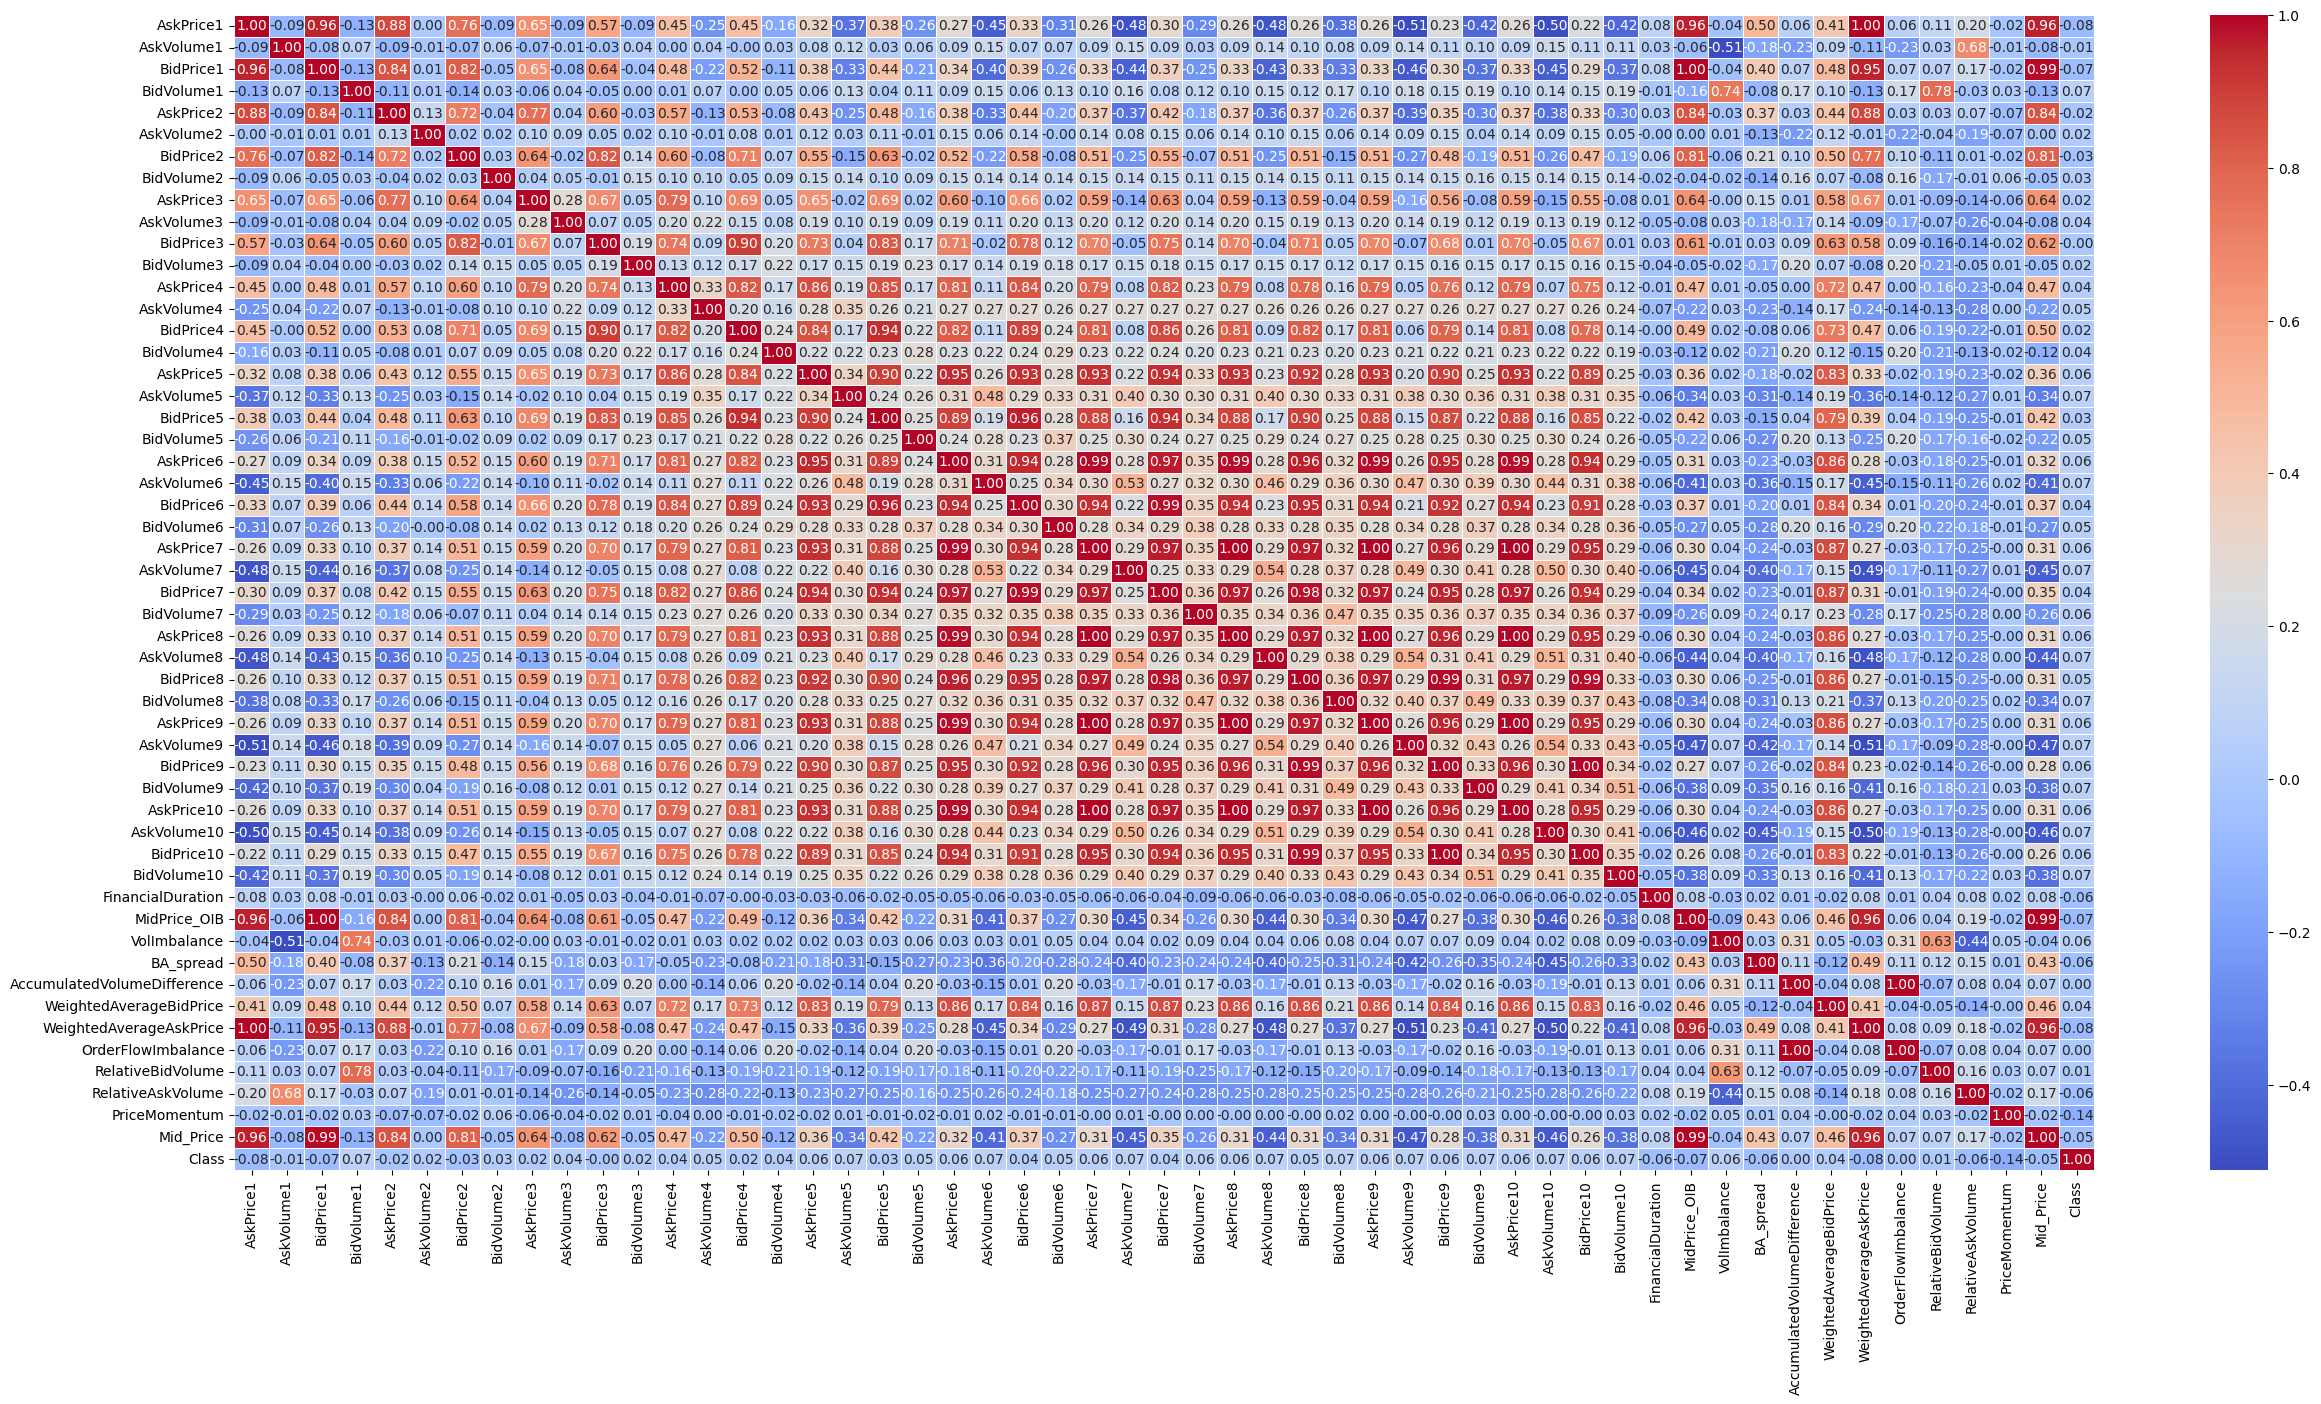

In [46]:
# A heatmap visualization of the correlation matrix using Spearman

corr_matrix = df_final.corr(method='spearman')
fig, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


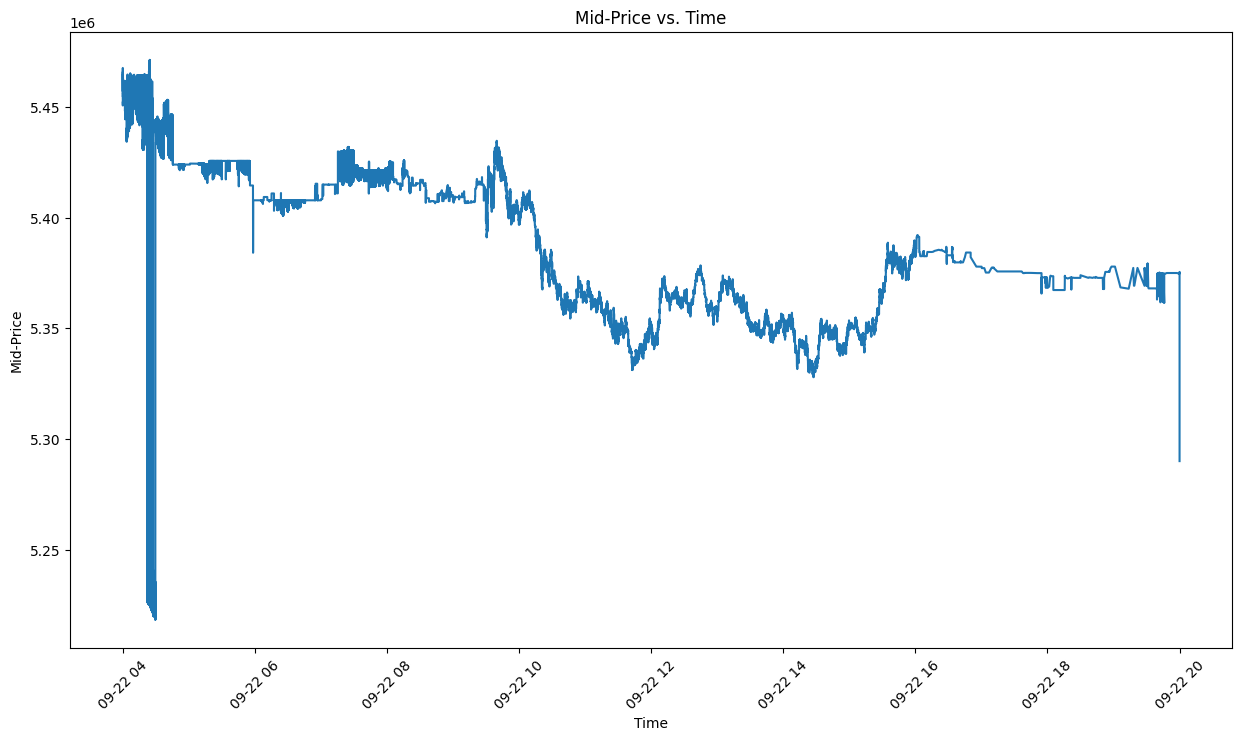

In [10]:
# plot the "Mid_Price" column
plt.figure(figsize=(15, 8))

plt.plot(df_final["Mid_Price"])

# rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# add axis labels and a title
plt.xlabel("Time")
plt.ylabel("Mid-Price")
plt.title("Mid-Price vs. Time")

# display the plot
plt.show()


In [47]:
# Applying PCA

def variances_pca(df):
    # Fit the PCA to all the features
    pca = PCA()
    pca.fit_transform(df)

    # print the variances of the first ten components
    print("Variance explained by the first ten components:")
    print(np.round(pca.explained_variance_[:10], 10))


variances_pca(df_features_new)


Variance explained by the first ten components:
[2.7877e+16 1.8081e+16 1.1758e+16 7.7181e+15 4.1169e+15 5.3618e+14
 1.1961e+14 6.6938e+13 5.4262e+13 3.3008e+13]


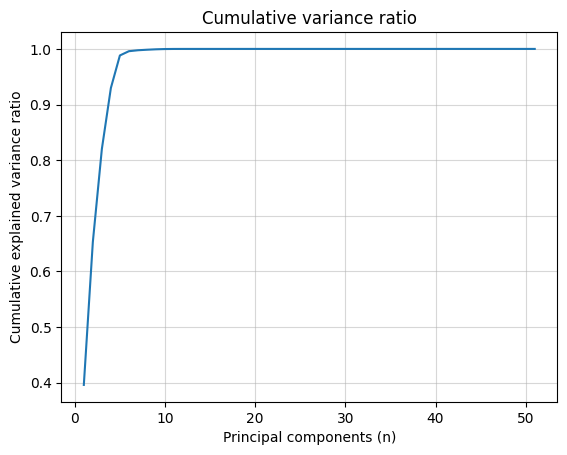

In [48]:
# (2) Your code goes here
def plot_graph(df):

    # Fit PCA to all features
    pca = PCA()
    pca.fit_transform(df)

    # Calculate and plot the cumulative variance ratio
    cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio)

    plt.xlabel("Principal components (n)")
    plt.ylabel("Cumulative explained variance ratio")
    plt.title("Cumulative variance ratio")
    plt.grid(alpha=0.5)
    plt.show()


plot_graph(df_features_new)


In [51]:
def find_components(df, total_var=[50, 60, 70, 80, 90, 95, 97, 99, 100]):
    pca = PCA()
    pca.fit_transform(df)
    min_components = []

    # Calculate the cumulative explained variance ratio
    cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
    for var in total_var:
        min_components.append(np.argmax(cumulative_var_ratio >= var * 0.01) + 1)

    # Calculate the number of principal components
    for i, var in enumerate(total_var):
        print(
            f"Number of principal components that explain {var}% of the variance is {min_components[i]}")


find_components(df_features_new, [50, 60, 70, 80, 90, 95, 97, 99, 100])


Number of principal components that explain 50% of the variance is 2
Number of principal components that explain 60% of the variance is 2
Number of principal components that explain 70% of the variance is 3
Number of principal components that explain 80% of the variance is 3
Number of principal components that explain 90% of the variance is 4
Number of principal components that explain 95% of the variance is 5
Number of principal components that explain 97% of the variance is 5
Number of principal components that explain 99% of the variance is 6
Number of principal components that explain 100% of the variance is 43


In [52]:
# We will extract the principal components equal to six as it explains 99%
# of variance

pca = PCA(n_components=6)

# Fit and transform the DataFrame
principal_components = pca.fit_transform(df_features_new)

# Create a new DataFrame with the principal components
df_principal_components = pd.DataFrame(
    data=principal_components, columns=[
        'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

print(df_principal_components.shape)


(559716, 6)


In [53]:
# Using 51 features for XGBoost Regressor
xgboost_rmse_51 = xgboost_cross_validation(
    df_features_new, df_final.iloc[:, -2])


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 50886 TEST: 50883
----------------------------------------------------------------------
testScore: 7728.48091072208
Fold 2:
TRAIN: 101769 TEST: 50883
----------------------------------------------------------------------
testScore: 6109.653589061949
Fold 3:
TRAIN: 152652 TEST: 50883
----------------------------------------------------------------------
testScore: 8380.383874757921
Fold 4:
TRAIN: 203535 TEST: 50883
----------------------------------------------------------------------
testScore: 6468.886392234103
Fold 5:
TRAIN: 254418 TEST: 50883
----------------------------------------------------------------------
testScore: 762.5626617921976
Fold 6:
TRAIN: 305301 TEST: 50883
----------------------------------------------------------------------
testScore: 758.0055107533772
Fold 7:
TRAIN: 356184 TEST: 50883
----------------------------

In [54]:
# Using only 40 features (without feature engineering)
xgboost_rmse_40 = xgboost_cross_validation(
    df_features_new.iloc[:, :40], df_final.iloc[:, -2])


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 50886 TEST: 50883
----------------------------------------------------------------------
testScore: 10658.346762982528
Fold 2:
TRAIN: 101769 TEST: 50883
----------------------------------------------------------------------
testScore: 6996.091035111965
Fold 3:
TRAIN: 152652 TEST: 50883
----------------------------------------------------------------------
testScore: 10788.392867137818
Fold 4:
TRAIN: 203535 TEST: 50883
----------------------------------------------------------------------
testScore: 15069.404753612402
Fold 5:
TRAIN: 254418 TEST: 50883
----------------------------------------------------------------------
testScore: 826.3419788497231
Fold 6:
TRAIN: 305301 TEST: 50883
----------------------------------------------------------------------
testScore: 816.947761150632
Fold 7:
TRAIN: 356184 TEST: 50883
-------------------------

In [55]:
# XGBoost Regressor with six principal components
xgboost_rmse_6 = xgboost_cross_validation(
    df_principal_components, df_final.iloc[:, -2])


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 50886 TEST: 50883
----------------------------------------------------------------------
testScore: 67093.08882589647
Fold 2:
TRAIN: 101769 TEST: 50883
----------------------------------------------------------------------
testScore: 13903.40669469478
Fold 3:
TRAIN: 152652 TEST: 50883
----------------------------------------------------------------------
testScore: 18154.00052411622
Fold 4:
TRAIN: 203535 TEST: 50883
----------------------------------------------------------------------
testScore: 31446.732259531593
Fold 5:
TRAIN: 254418 TEST: 50883
----------------------------------------------------------------------
testScore: 1108.469381862441
Fold 6:
TRAIN: 305301 TEST: 50883
----------------------------------------------------------------------
testScore: 1301.7569558034957
Fold 7:
TRAIN: 356184 TEST: 50883
-------------------------

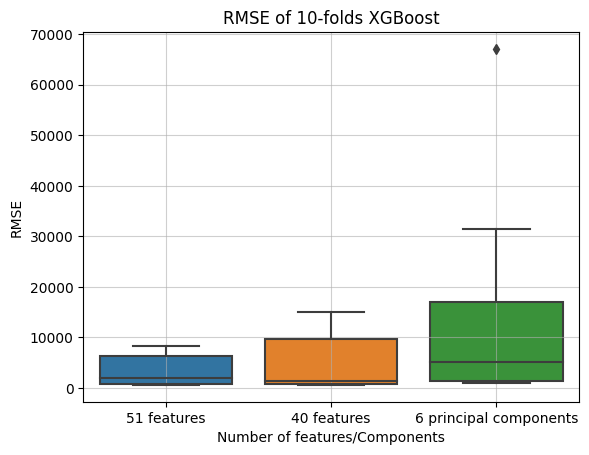

Mean of 51 features:3567.4403657866596
Mean of 40 features:4913.90827258554
Mean of 6 principal components:14577.383297950666


Median of 51 features:1914.7292456106836
Median of 40 features:1283.317290735159
Median of 6 principal components:5171.716780795349


In [58]:
# Plot the box plot for RMSE
all_rmse = [xgboost_rmse_51, xgboost_rmse_40, xgboost_rmse_6]
names = ["51 features", "40 features", "6 principal components"]
sns.boxplot(data=all_rmse)
plt.xticks(range(len(all_rmse)), names)
plt.xlabel('Number of features/Components')
plt.title('RMSE of 10-folds XGBoost')
plt.ylabel('RMSE')
plt.grid(alpha=0.6)
plt.show()

print(f"Mean of 51 features:{np.mean(xgboost_rmse_51)}")
print(f"Mean of 40 features:{np.mean(xgboost_rmse_40)}")
print(f"Mean of 6 principal components:{np.mean(xgboost_rmse_6)}")
print("\n")
print(f"Median of 51 features:{np.median(xgboost_rmse_51)}")
print(f"Median of 40 features:{np.median(xgboost_rmse_40)}")
print(f"Median of 6 principal components:{np.median(xgboost_rmse_6)}")


In [85]:
# Hyperparameter tuning for LSTM architecture

grid_search(X_train_lstm, y_train_lstm)

<ipython-input-84-828ba41365d1>:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(
/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters:  {'dropout_rate': 0.1, 'num_units': 128}
Best Score:  0.002243122644722462


LSTM Autoencoder with 40 features + 20 latent Regressor Model 1
Epoch 1/50
222/222 [==============================] - 25s 63ms/step - loss: 0.0207 - val_loss: 0.0129
Epoch 2/50
222/222 [==============================] - 12s 56ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 3/50
222/222 [==============================] - 12s 54ms/step - loss: 0.0016 - val_loss: 8.2034e-04
Epoch 4/50
222/222 [==============================] - 13s 59ms/step - loss: 8.2524e-04 - val_loss: 5.3637e-04
Epoch 5/50
222/222 [==============================] - 14s 62ms/step - loss: 4.8580e-04 - val_loss: 3.8074e-04
Epoch 6/50
222/222 [==============================] - 13s 60ms/step - loss: 3.0021e-04 - val_loss: 2.8894e-04
Epoch 7/50
222/222 [==============================] - 13s 60ms/step - loss: 2.1314e-04 - val_loss: 2.3727e-04
Epoch 8/50
222/222 [==============================] - 13s 60ms/step - loss: 1.6737e-04 - val_loss: 2.0050e-04
Epoch 9/50
222/222 [==============================] - 13s 60ms/step - loss: 

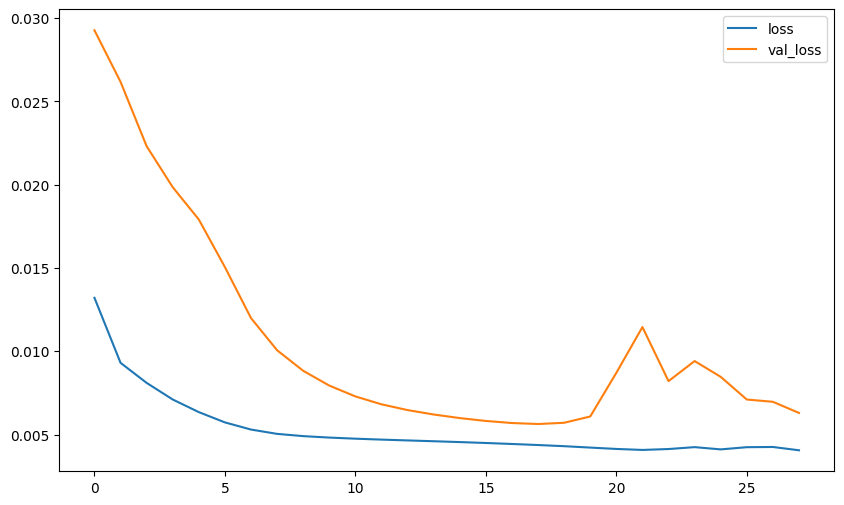

35/35 [==============================] - 1s 12ms/step


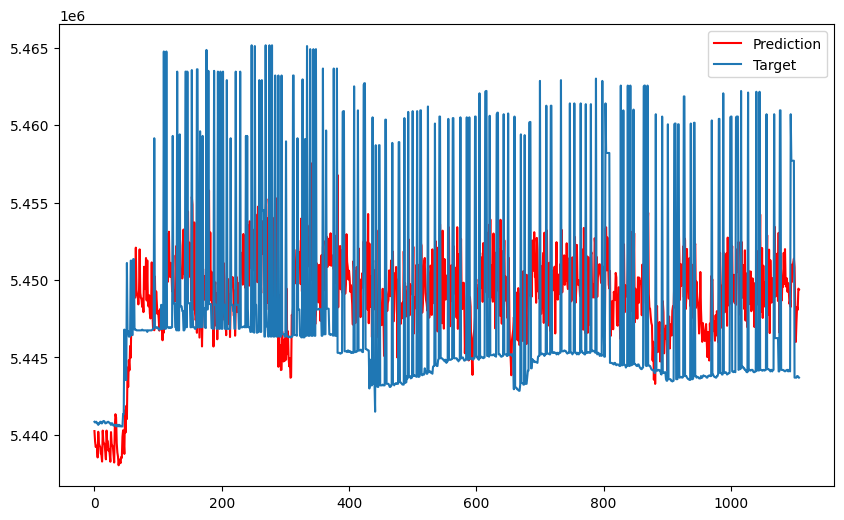

RMSE LSTM: 6111.198211230053
Random Forest with 40 features Regressor Model 1
RMSE Random Forest: 7370.568034085792
XGBoost with 40 features Regressor Model 1


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 7092.782294456897
Empty DataFrame
Columns: [Online iteration, LSTM AE 60 features, LSTM AE 20 latent, MLP, Vanilla LSTM, Random Forests, XGBoost]
Index: []
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent          MLP  \
0                1          6801.212989        6669.309465  6405.397087   

   Vanilla LSTM  Random Forests      XGBoost  
0   6111.198211     7370.568034  7092.782294  
LSTM Autoencoder with 40 features + 20 latent Regressor Model 2
Epoch 1/50
222/222 [==============================] - 21s 68ms/step - loss: 0.0299 - val_loss: 0.0141
Epoch 2/50
222/222 [==============================] - 14s 62ms/step - loss: 0.0079 - val_loss: 0.0048
Epoch 3/50
222/222 [==============================] - 13s 61ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 4/50
222/222 [==============================] - 15s 69ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 5/50
222/222 [==============================] - 13s 60ms/step - loss: 0.0015 - val_loss: 8.0682e-04
Epoch 6

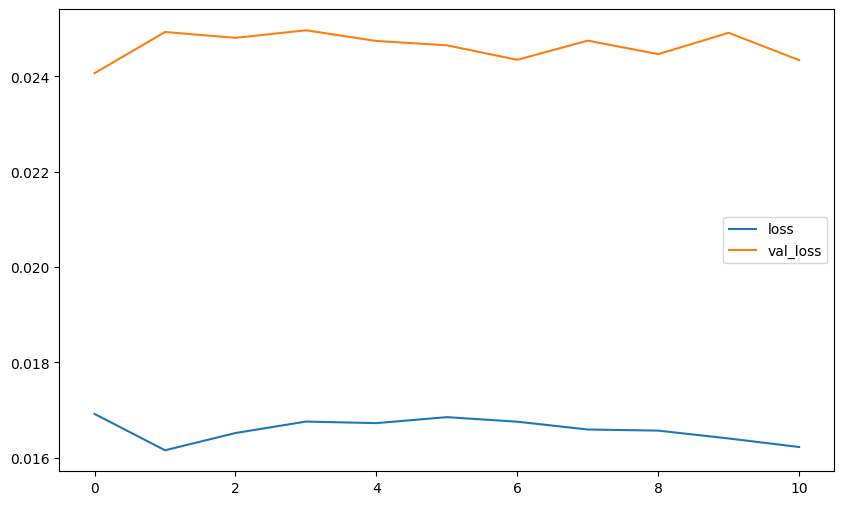

35/35 [==============================] - 1s 12ms/step


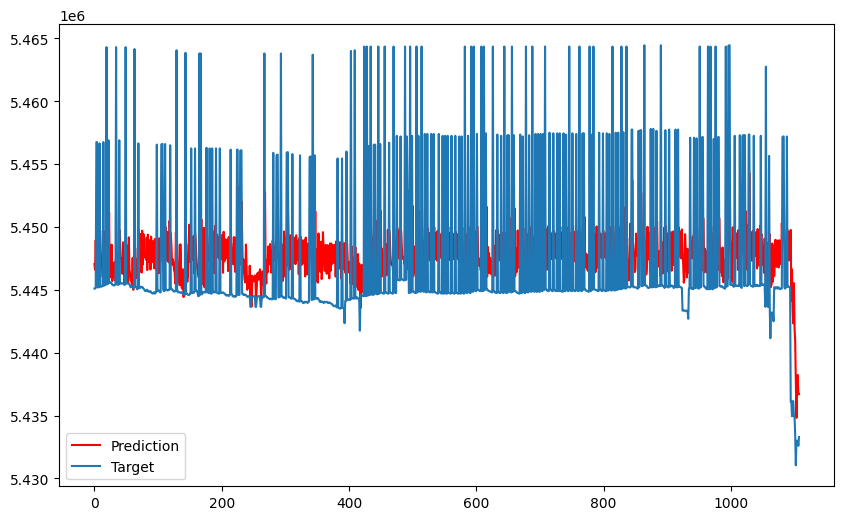

RMSE LSTM: 5466.380136374633
Random Forest with 40 features Regressor Model 2
RMSE Random Forest: 6922.04690063283
XGBoost with 40 features Regressor Model 2
RMSE XGBoost: 5733.49782853154
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent          MLP  \
0                1          6801.212989        6669.309465  6405.397087   

   Vanilla LSTM  Random Forests      XGBoost  
0   6111.198211     7370.568034  7092.782294  
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent          MLP  \
0                1          6801.212989        6669.309465  6405.397087   
1                2          6796.652324        6725.706775  6464.807039   

   Vanilla LSTM  Random Forests      XGBoost  
0   6111.198211     7370.568034  7092.782294  
1   5466.380136     6922.046901  5733.497829  


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


LSTM Autoencoder with 40 features + 20 latent Regressor Model 3
Epoch 1/50
222/222 [==============================] - 20s 71ms/step - loss: 0.0352 - val_loss: 0.0280
Epoch 2/50
222/222 [==============================] - 15s 66ms/step - loss: 0.0116 - val_loss: 0.0132
Epoch 3/50
222/222 [==============================] - 15s 65ms/step - loss: 0.0043 - val_loss: 0.0083
Epoch 4/50
222/222 [==============================] - 15s 66ms/step - loss: 0.0022 - val_loss: 0.0058
Epoch 5/50
222/222 [==============================] - 15s 66ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 6/50
222/222 [==============================] - 15s 66ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 7/50
222/222 [==============================] - 15s 66ms/step - loss: 8.7466e-04 - val_loss: 0.0037
Epoch 8/50
222/222 [==============================] - 15s 66ms/step - loss: 6.9645e-04 - val_loss: 0.0034
Epoch 9/50
222/222 [==============================] - 15s 66ms/step - loss: 5.7018e-04 - val_loss: 0.0031
Epoch 

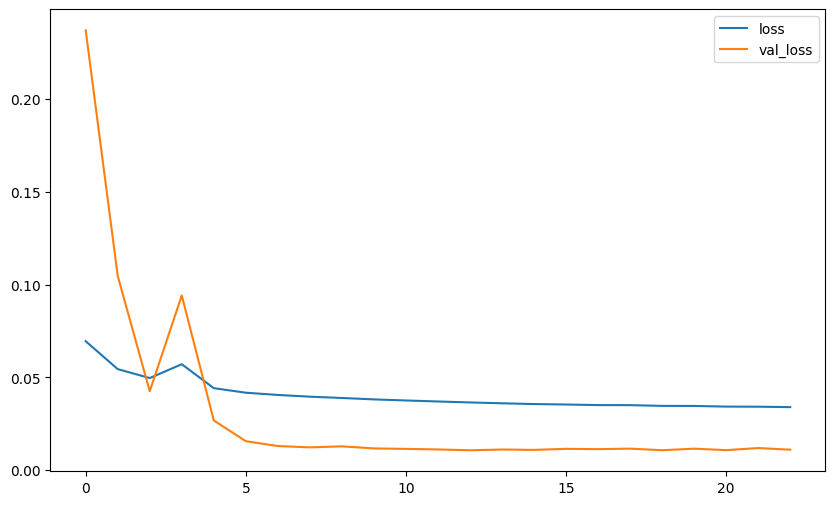

35/35 [==============================] - 1s 12ms/step


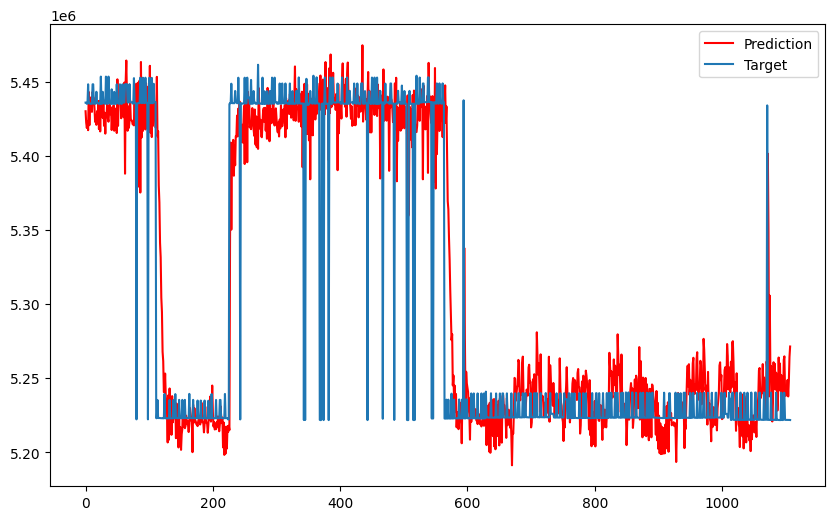

RMSE LSTM: 40798.79827132751
Random Forest with 40 features Regressor Model 3
RMSE Random Forest: 89262.53275618645
XGBoost with 40 features Regressor Model 3


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 88679.67587764817
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent          MLP  \
0                1          6801.212989        6669.309465  6405.397087   
1                2          6796.652324        6725.706775  6464.807039   

   Vanilla LSTM  Random Forests      XGBoost  
0   6111.198211     7370.568034  7092.782294  
1   5466.380136     6922.046901  5733.497829  
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
LSTM Autoencoder with 40 features + 20 latent Regressor Model 4
Epoch 1/50
222/222 [====================

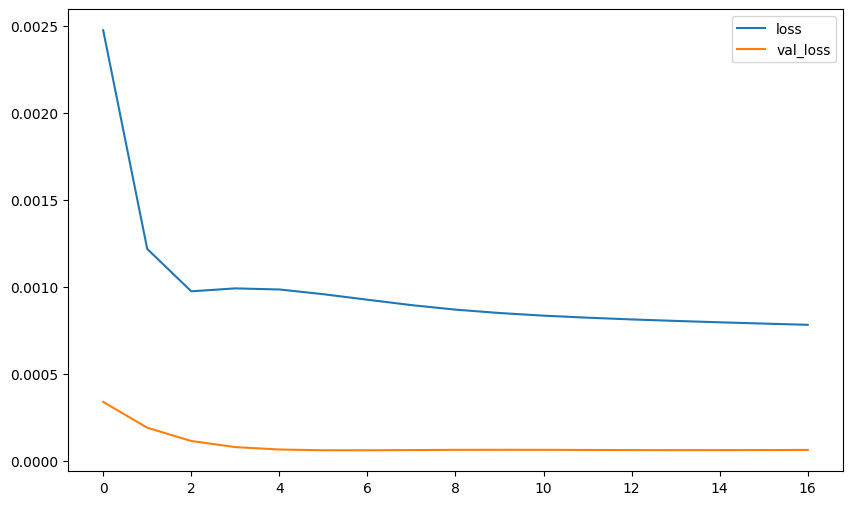

35/35 [==============================] - 1s 12ms/step


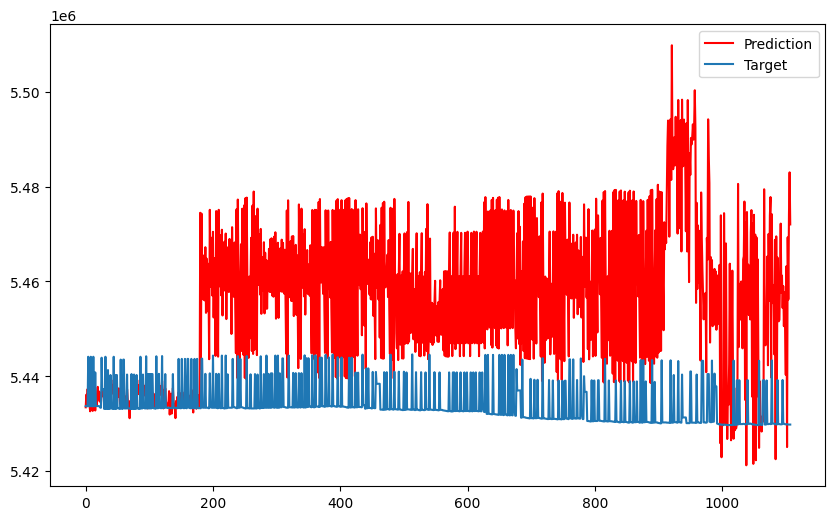

RMSE LSTM: 27032.985654241853
Random Forest with 40 features Regressor Model 4
RMSE Random Forest: 31297.25676396675
XGBoost with 40 features Regressor Model 4


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 4920.329301937923
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782

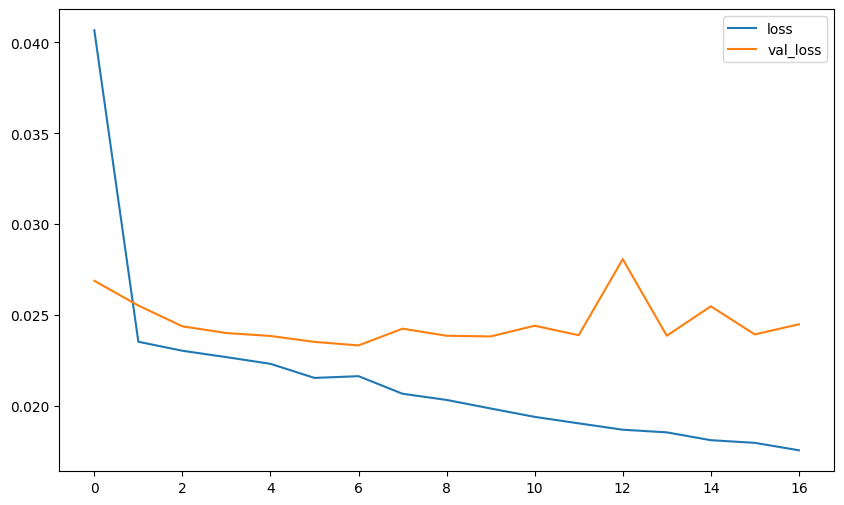

35/35 [==============================] - 1s 15ms/step


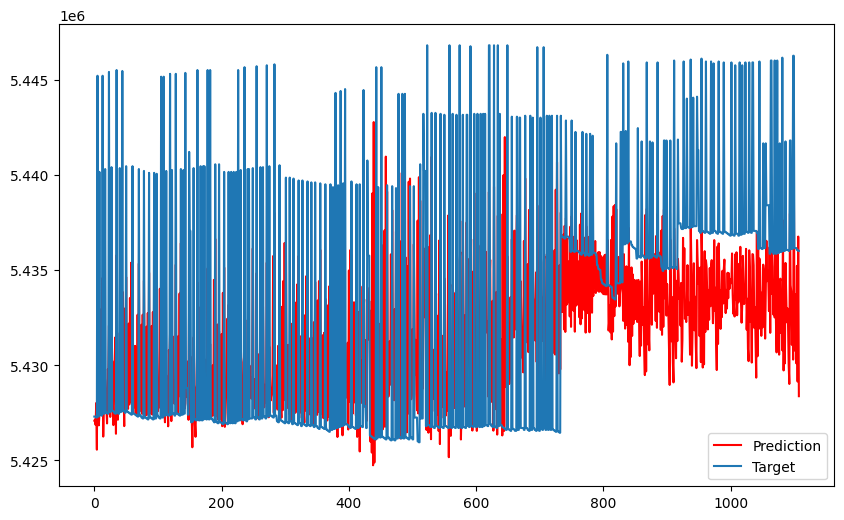

RMSE LSTM: 5271.140210514984
Random Forest with 40 features Regressor Model 5
RMSE Random Forest: 6399.077296048957
XGBoost with 40 features Regressor Model 5


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 6182.607952959657
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664    

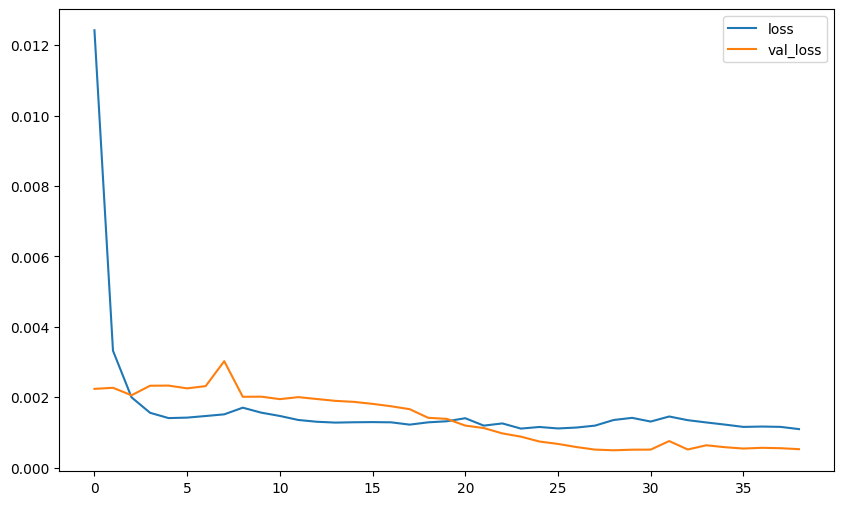

35/35 [==============================] - 1s 12ms/step


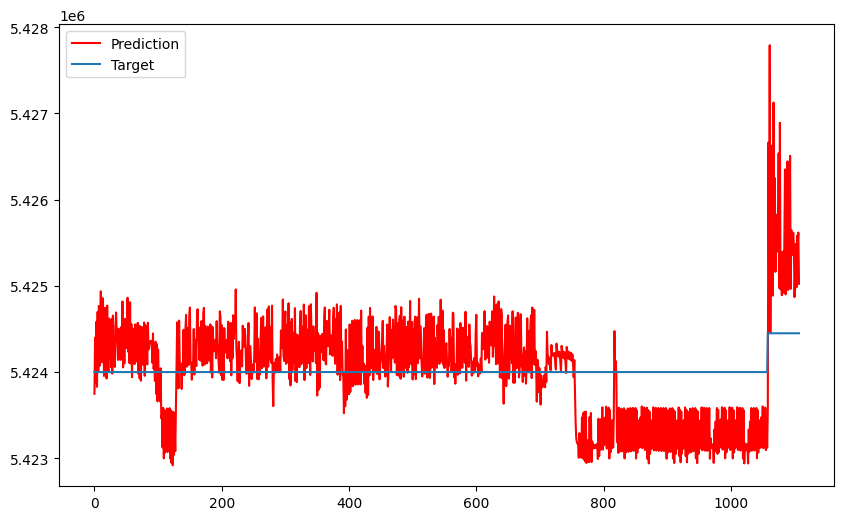

RMSE LSTM: 583.5261255245348
Random Forest with 40 features Regressor Model 6
RMSE Random Forest: 318.94621397364284
XGBoost with 40 features Regressor Model 6


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 275.3053548205286
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
4   5271.140211     6399.077296   6182.607953  
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.80703

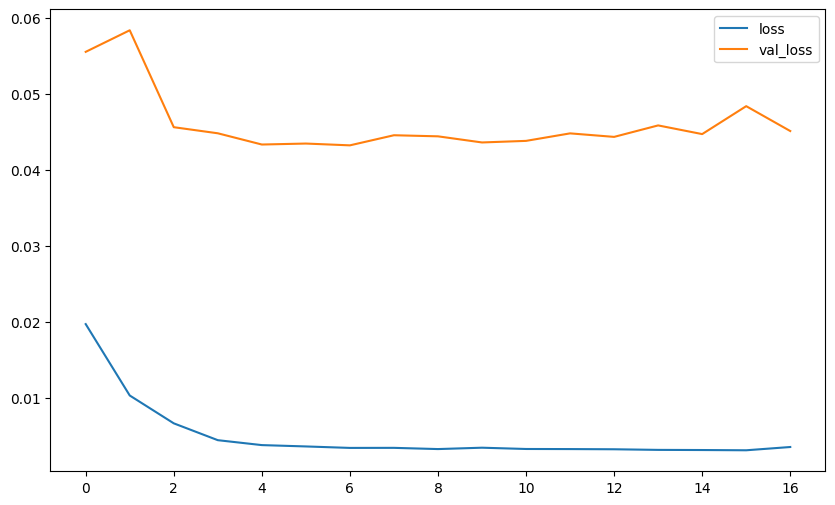

35/35 [==============================] - 1s 12ms/step


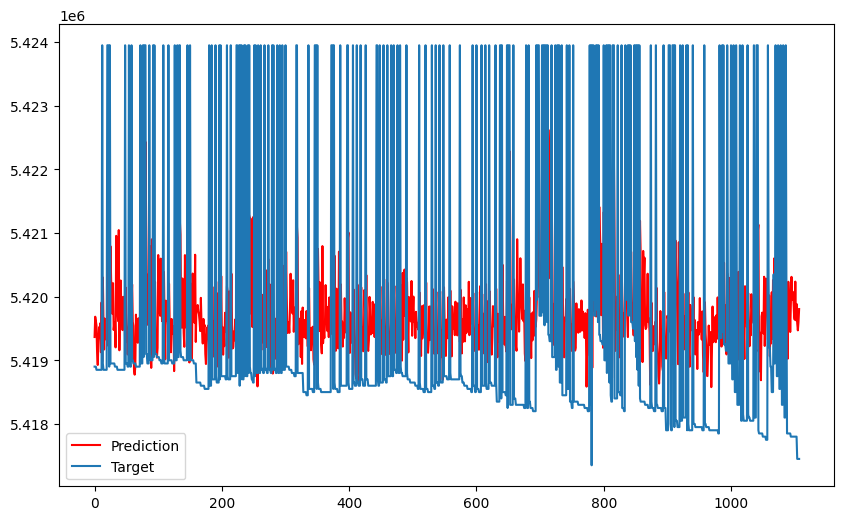

RMSE LSTM: 2000.3214673392297
Random Forest with 40 features Regressor Model 7
RMSE Random Forest: 4629.383784466577
XGBoost with 40 features Regressor Model 7
RMSE XGBoost: 2656.5905140143277
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   
5                6          1453.591891        1708.294980   1389.734720   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
4   5271.140211     6399.077296   

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


LSTM Autoencoder with 40 features + 20 latent Regressor Model 8
Epoch 1/50
222/222 [==============================] - 21s 71ms/step - loss: 0.0495 - val_loss: 0.0312
Epoch 2/50
222/222 [==============================] - 15s 67ms/step - loss: 0.0174 - val_loss: 0.0107
Epoch 3/50
222/222 [==============================] - 15s 67ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 4/50
222/222 [==============================] - 15s 67ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 5/50
222/222 [==============================] - 15s 67ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/50
222/222 [==============================] - 16s 70ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/50
222/222 [==============================] - 15s 68ms/step - loss: 8.2130e-04 - val_loss: 9.8656e-04
Epoch 8/50
222/222 [==============================] - 15s 67ms/step - loss: 6.7418e-04 - val_loss: 8.9378e-04
Epoch 9/50
222/222 [==============================] - 15s 67ms/step - loss: 5.5841e-04 - val_loss: 7.146

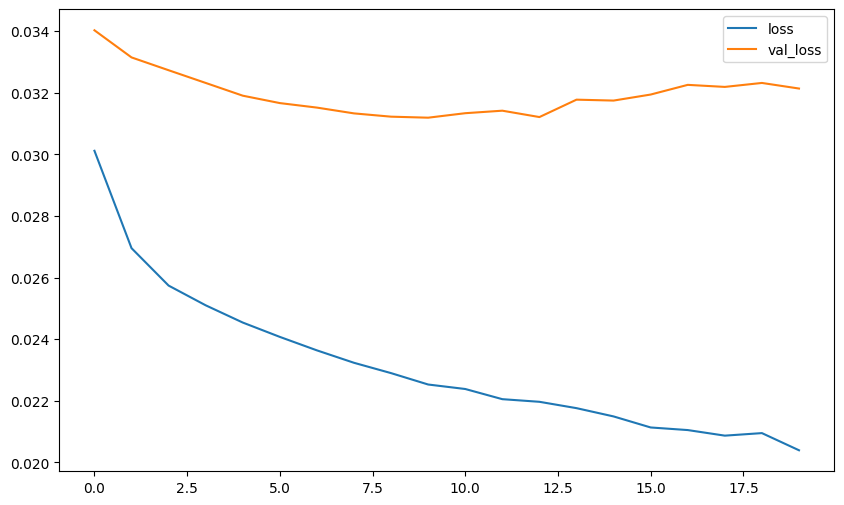

35/35 [==============================] - 1s 13ms/step


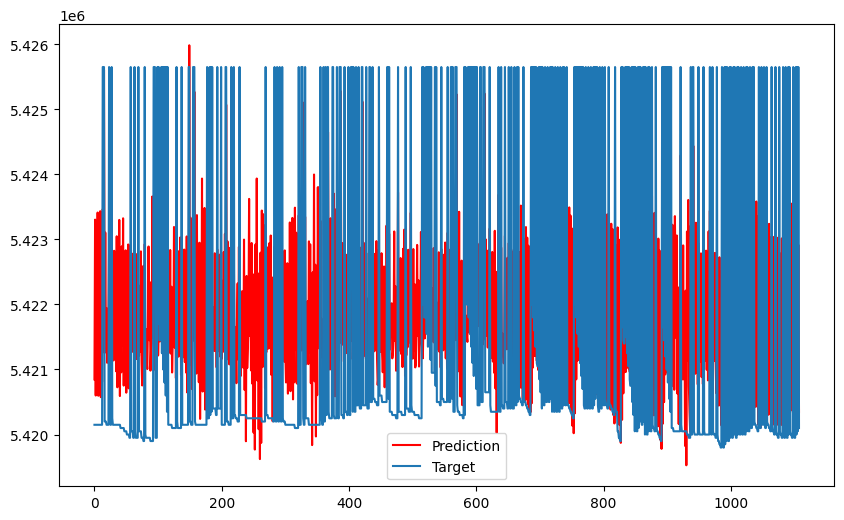

RMSE LSTM: 1983.6692343530947
Random Forest with 40 features Regressor Model 8
RMSE Random Forest: 2452.3877883573587
XGBoost with 40 features Regressor Model 8


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 2612.0196150952906
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   
5                6          1453.591891        1708.294980   1389.734720   
6                7          4490.239894        5149.406566   2445.770109   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
4   5271.140211     6399.077296   6182.607953  
5    583.526126      318.946214    275.305355  
6   2000.321467     46

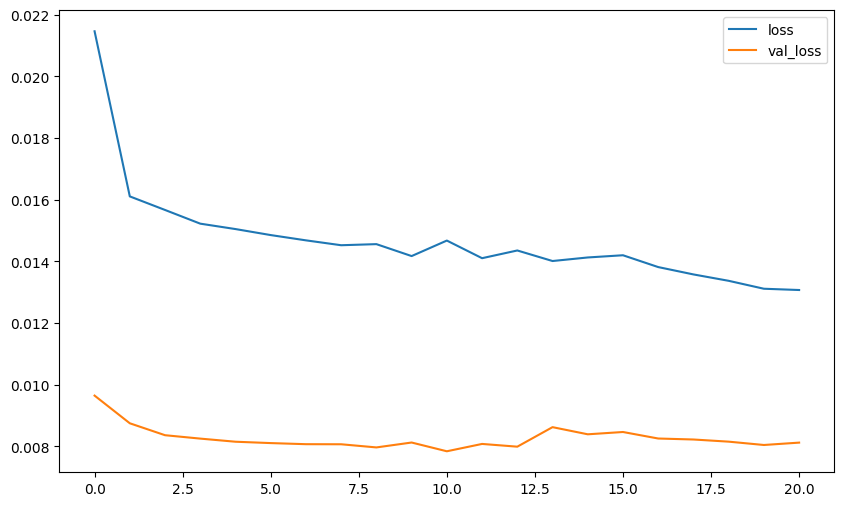

35/35 [==============================] - 1s 13ms/step


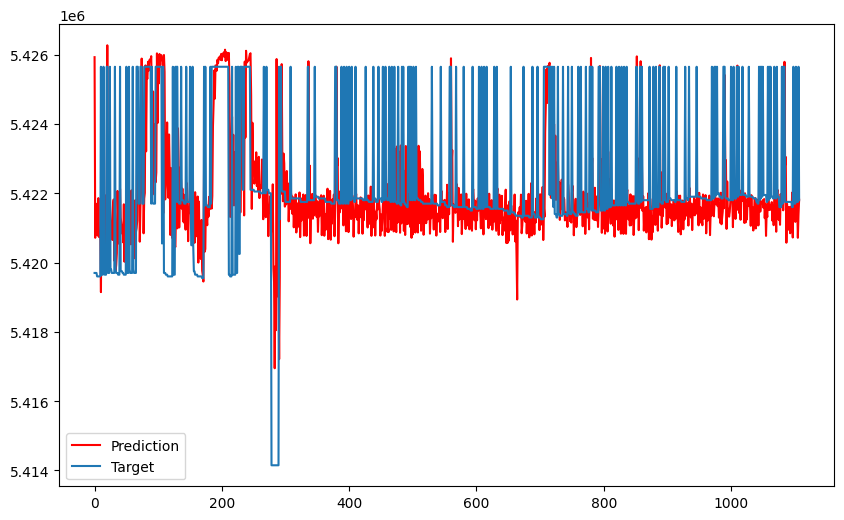

RMSE LSTM: 1828.3629248889026
Random Forest with 40 features Regressor Model 9
RMSE Random Forest: 1997.751037795631
XGBoost with 40 features Regressor Model 9


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 2065.6005763630656
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   
5                6          1453.591891        1708.294980   1389.734720   
6                7          4490.239894        5149.406566   2445.770109   
7                8          2116.571344        2019.415155   2135.162202   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
4   5271.140211     6399.077296   6182.607

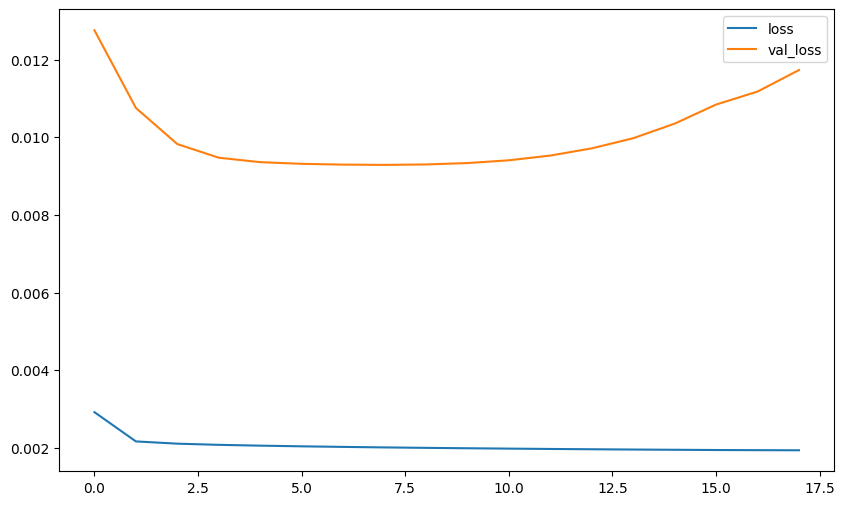

35/35 [==============================] - 1s 18ms/step


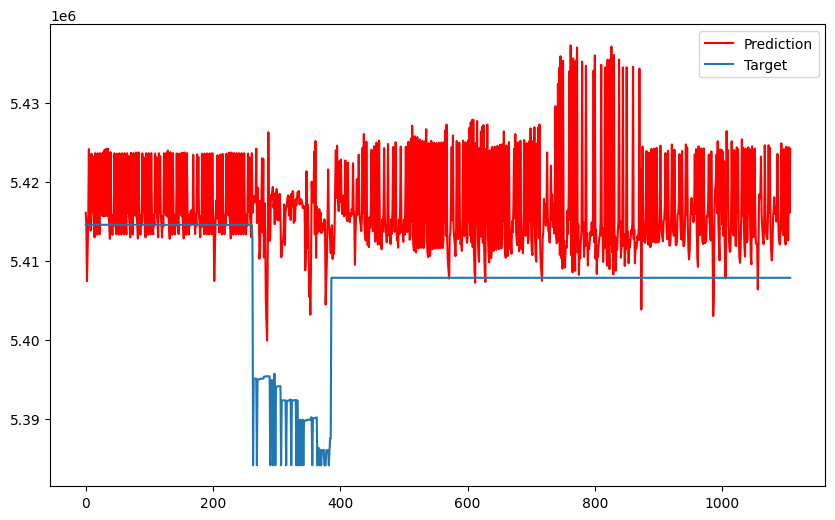

RMSE LSTM: 12153.312779950276
Random Forest with 40 features Regressor Model 10
RMSE Random Forest: 13174.06131871578
XGBoost with 40 features Regressor Model 10


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 9475.655667334799
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   
5                6          1453.591891        1708.294980   1389.734720   
6                7          4490.239894        5149.406566   2445.770109   
7                8          2116.571344        2019.415155   2135.162202   
8                9          1973.031398        1926.461759   2000.930815   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654

In [32]:
# LSTM AE 60 features + LSTM AE 40 features + MLP + Vanilla LSTM +
# RandomForestRegressor + XGBoost Online Learning

# Define on how many we want to split the data
# We simulate that 100 splits = 100 events to save resource in this assignment
num_splits = 100

# Calculate the size of each split
split_size = len(df_final) // num_splits

# Split the DataFrame into a list of smaller DataFrames
data_splits = [
    df_final.iloc[i * split_size:(i + 1) * split_size] for i in range(num_splits)]

# If there are any remaining data points, add them to the last split
if len(data_splits) % num_splits != 0:
    data_splits[-1] = data_splits[-1].append(
        df_final.iloc[num_splits * split_size:])

# How many data we want to use in this online learning simulation
# E.g. : data_chunk = 10 means 10 out of 100 chunks (10% data)
data_chunk = 10

# Create empty dataframe as a table to save RMSE result
df_results = pd.DataFrame(
    columns=[
        'Online iteration',
        'LSTM AE 60 features',
        'LSTM AE 20 latent',
        'MLP',
        'Vanilla LSTM',
        'Random Forests',
        'XGBoost'])

for i, df_content in enumerate(data_splits):
    if i == data_chunk:
        break

    # Select all column, except the class label (last column)
    df_chunk = df_content.iloc[:, 0:52]
    array_chunk = df_chunk.values

    # Normalise the stock array
    array, scaler = normalise_data(array_chunk)

    # Preparing the data for non-LSTM models (Random Forests, XGBoost, MLP)
    # Only use original 40 features for this online learning
    features = array[:, :40]
    label = array[:, -1]
    X, X_test, y, y_test = train_test_split(
        features, label, test_size=0.20, random_state=0, shuffle=False)
    X_train, X_validate, y_train, y_validate = train_test_split(
        X, y, test_size=0.20, random_state=0, shuffle=False)

    # Preparing the data for LSTM models (LSTM, LSTM AE)
    look_back = 60  # We use 60 days as the historical data in LSTM
    horizon = 1
    features_array = np.concatenate((features, label.reshape(-1, 1)), axis=1)
    features_lstm, label_lstm = process_lstm_data(
        features_array, look_back, horizon, jump=1)
    X_lstm, X_test_lstm, y_lstm, y_test_lstm = train_test_split(
        features_lstm, label_lstm, test_size=0.20, random_state=0, shuffle=False)
    X_train_lstm, X_validate_lstm, y_train_lstm, y_validate_lstm = train_test_split(
        X_lstm, y_lstm, test_size=0.20, random_state=0, shuffle=False)

    print(
        f"LSTM Autoencoder with 40 features + 20 latent Regressor Model {i+1}")
    rmse_model1 = lstm_autoencoder_plusfeature(
        X_train_lstm,
        X_validate_lstm,
        X_test_lstm,
        y_train_lstm,
        y_validate_lstm,
        y_test_lstm,
        i,
        20)
    print(f"LSTM Autoencoder with 20 latent Regressor Model {i+1}")
    rmse_model2 = lstm_autoencoder(
        X_train_lstm,
        X_validate_lstm,
        X_test_lstm,
        y_train_lstm,
        y_validate_lstm,
        y_test_lstm,
        i,
        20)
    print(f"MLP with 40 features Regressor Model {i+1}")
    rmse_model3 = mlp_regression(
        X_train,
        y_train,
        X_validate,
        y_validate,
        X_test,
        y_test,
        i)
    print(f"Vanilla LSTM with 40 features Regressor Model {i+1}")
    rmse_model4 = lstm(
        X_train_lstm,
        X_validate_lstm,
        X_test_lstm,
        y_train_lstm,
        y_validate_lstm,
        y_test_lstm,
        i)
    print(f"Random Forest with 40 features Regressor Model {i+1}")
    rmse_model5 = random_forest_regressor(
        X_train,
        y_train,
        X_validate,
        y_validate,
        X_test,
        y_test,
        100,
        5,
        2,
        1,
        i)
    print(f"XGBoost with 40 features Regressor Model {i+1}")
    rmse_model6 = xgboost_regressor(
        X_train,
        y_train,
        X_validate,
        y_validate,
        X_test,
        y_test,
        i)
    print(df_results)
    df_results = pd.concat([df_results,
                            pd.DataFrame({'Online iteration': [i + 1],
                                          'LSTM AE 60 features': [rmse_model1],
                                          'LSTM AE 20 latent': [rmse_model2],
                                          'MLP': [rmse_model3],
                                          'Vanilla LSTM': [rmse_model4],
                                          'Random Forests': [rmse_model5],
                                          'XGBoost': [rmse_model6]})],
                           ignore_index=True)
    print(df_results)

# Save the RMSE result to CVS in Google Drive
df_results.to_csv(
    '/drive/My Drive/Colab Notebooks/FML 2/results.csv',
    index=True)


In [66]:
# Online learning results
df_results
# From the result, vanilla LSTM is chosen as the suitable algorithm

# Random Forests and XGBoost are rejected as the model
# due to the lack of ability to capture temporal dependency

# 20 latent dimension features extracted from AE do not
# improve the vanilla LSTM

Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   
5                6          1453.591891        1708.294980   1389.734720   
6                7          4490.239894        5149.406566   2445.770109   
7                8          2116.571344        2019.415155   2135.162202   
8                9          1973.031398        1926.461759   2000.930815   
9               10          8469.755017       12184.122087   6396.830073   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
4   5271.140211     6399.077296   6182.607953  
5    583.526126      318.946214    275.305355  
6   2000.321467     4629.383784   2656.590514  
7   1983.669234     2452.387788   2612.019615  
8   1828.362925     1997.751038   2065.600576  
9  12153.312780    13174.061319   9475.655667

LSTM with 51 features Regressor Model 1
Epoch 1/100
222/222 [==============================] - 12s 42ms/step - loss: 0.0157 - val_loss: 0.0340
Epoch 2/100
222/222 [==============================] - 7s 32ms/step - loss: 0.0097 - val_loss: 0.0365
Epoch 3/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0095 - val_loss: 0.0214
Epoch 4/100
222/222 [==============================] - 7s 33ms/step - loss: 0.0075 - val_loss: 0.0175
Epoch 5/100
222/222 [==============================] - 9s 38ms/step - loss: 0.0065 - val_loss: 0.0151
Epoch 6/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0058 - val_loss: 0.0131
Epoch 7/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 8/100
222/222 [==============================] - 8s 38ms/step - loss: 0.0051 - val_loss: 0.0093
Epoch 9/100
222/222 [==============================] - 7s 33ms/step - loss: 0.0049 - val_loss: 0.0082
Epoch 10/100
222/222 [===================

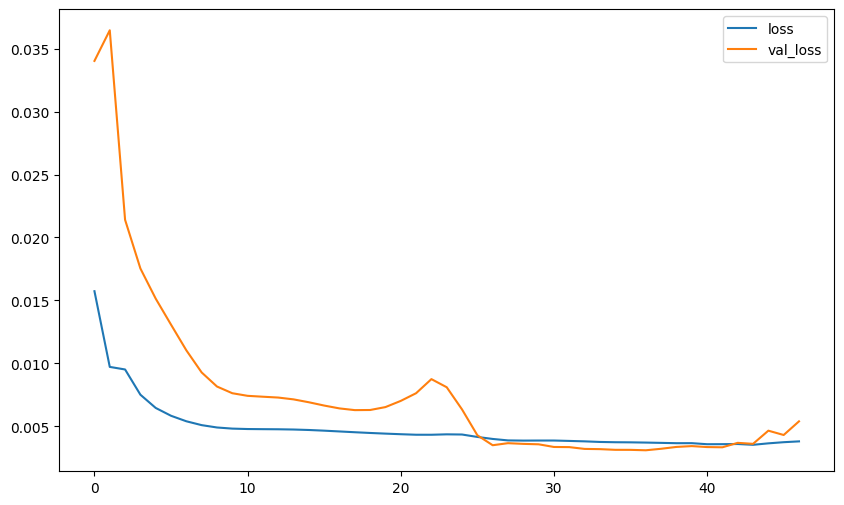

35/35 [==============================] - 1s 17ms/step


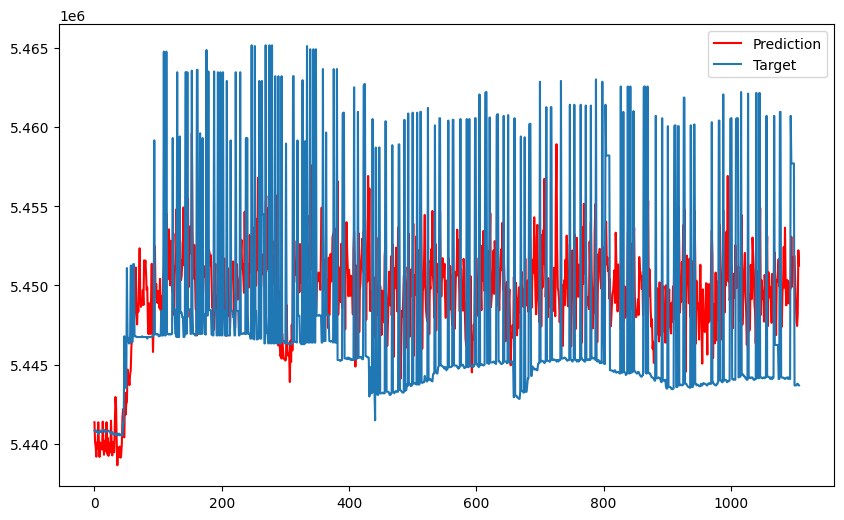

RMSE LSTM: 6289.685837670971
LSTM with 51 features Regressor Model 2
Epoch 1/100
222/222 [==============================] - 11s 40ms/step - loss: 0.0174 - val_loss: 0.0230
Epoch 2/100
222/222 [==============================] - 8s 37ms/step - loss: 0.0161 - val_loss: 0.0240
Epoch 3/100
222/222 [==============================] - 10s 43ms/step - loss: 0.0170 - val_loss: 0.0229
Epoch 4/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0160 - val_loss: 0.0237
Epoch 5/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0169 - val_loss: 0.0226
Epoch 6/100
222/222 [==============================] - 7s 33ms/step - loss: 0.0158 - val_loss: 0.0234
Epoch 7/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0166 - val_loss: 0.0226
Epoch 8/100
222/222 [==============================] - 9s 38ms/step - loss: 0.0156 - val_loss: 0.0233
Epoch 9/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0161 - val_loss: 0.0226
Epoch 10/10

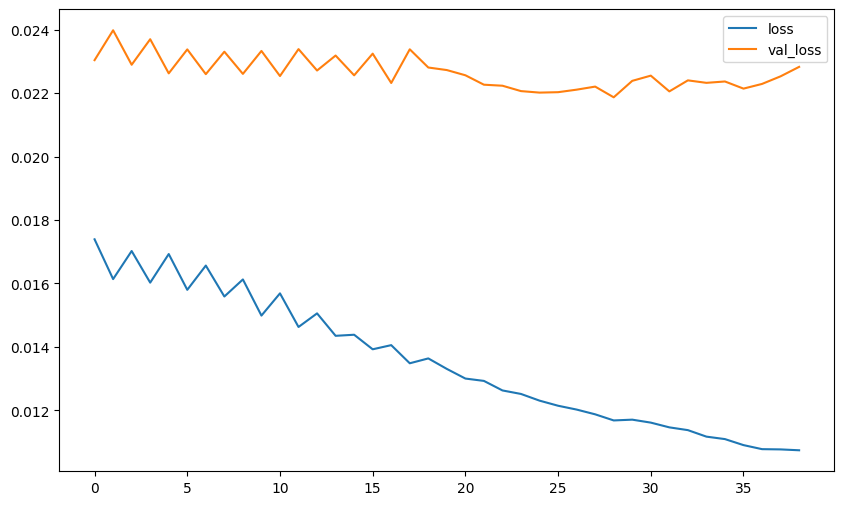

35/35 [==============================] - 1s 12ms/step


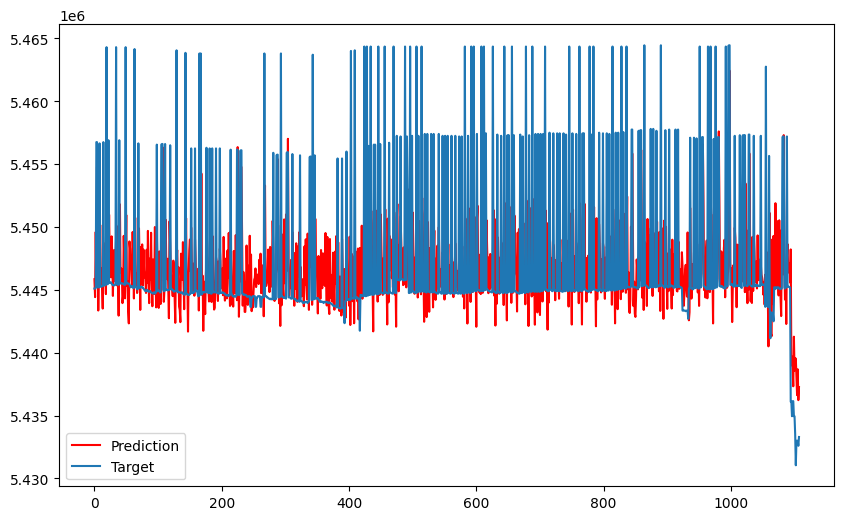

RMSE LSTM: 5412.297878747417
LSTM with 51 features Regressor Model 3
Epoch 1/100
222/222 [==============================] - 12s 44ms/step - loss: 0.0548 - val_loss: 0.0278
Epoch 2/100
222/222 [==============================] - 8s 38ms/step - loss: 0.0559 - val_loss: 0.0318
Epoch 3/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0396 - val_loss: 0.0256
Epoch 4/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0379 - val_loss: 0.0259
Epoch 5/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0371 - val_loss: 0.0291
Epoch 6/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0363 - val_loss: 0.0256
Epoch 7/100
222/222 [==============================] - 7s 34ms/step - loss: 0.0358 - val_loss: 0.0220
Epoch 8/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0352 - val_loss: 0.0247
Epoch 9/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0349 - val_loss: 0.0242
Epoch 10/100

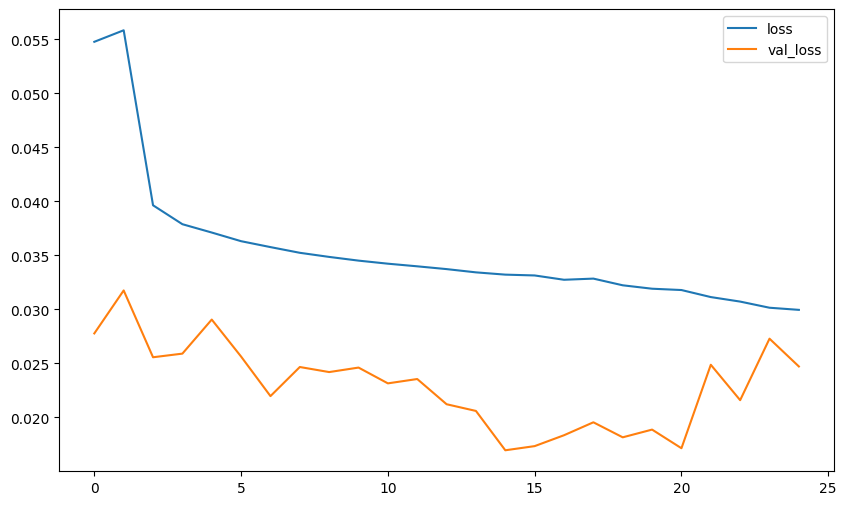

35/35 [==============================] - 1s 17ms/step


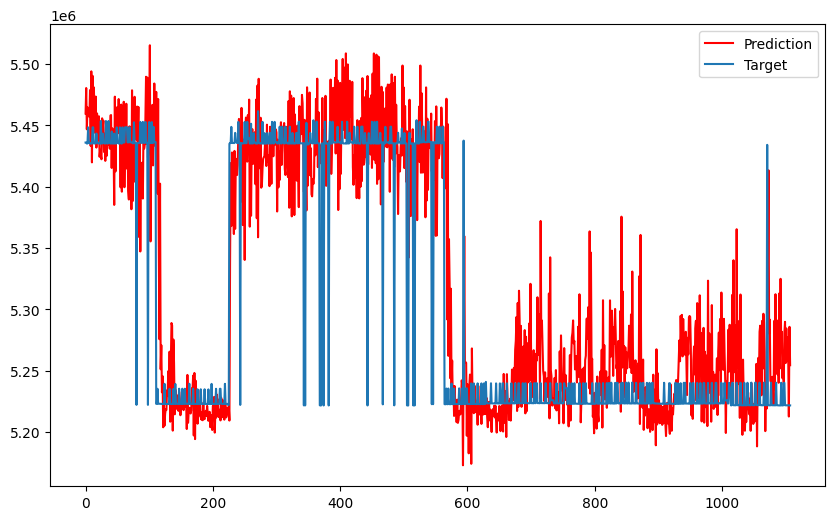

RMSE LSTM: 49965.176509054785
LSTM with 51 features Regressor Model 4
Epoch 1/100
222/222 [==============================] - 11s 37ms/step - loss: 0.0025 - val_loss: 1.9675e-04
Epoch 2/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0025 - val_loss: 1.3457e-04
Epoch 3/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0010 - val_loss: 5.9332e-05
Epoch 4/100
222/222 [==============================] - 8s 35ms/step - loss: 9.5092e-04 - val_loss: 7.6540e-05
Epoch 5/100
222/222 [==============================] - 9s 43ms/step - loss: 9.4566e-04 - val_loss: 6.3123e-05
Epoch 6/100
222/222 [==============================] - 8s 34ms/step - loss: 9.0690e-04 - val_loss: 9.8087e-05
Epoch 7/100
222/222 [==============================] - 9s 42ms/step - loss: 8.7326e-04 - val_loss: 8.8947e-05
Epoch 8/100
222/222 [==============================] - 8s 35ms/step - loss: 8.4937e-04 - val_loss: 1.3295e-04
Epoch 9/100
222/222 [==============================] - 9s 42m

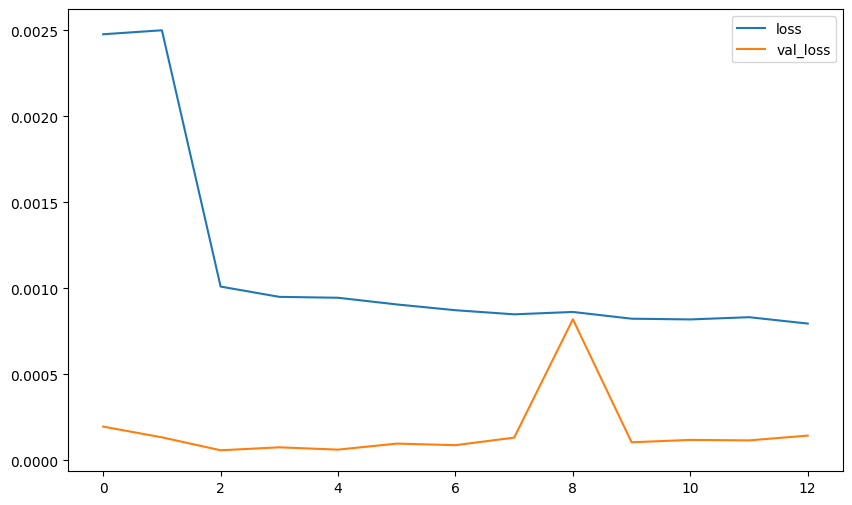

35/35 [==============================] - 1s 12ms/step


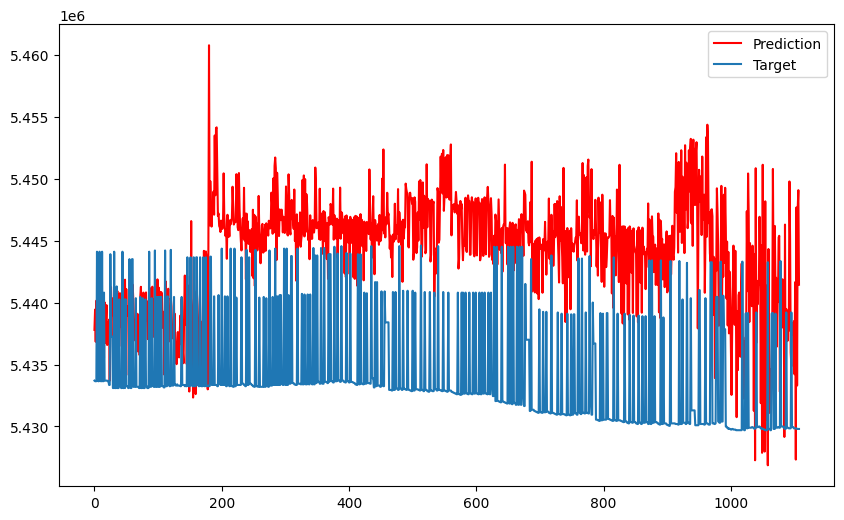

RMSE LSTM: 11721.471020232862
LSTM with 51 features Regressor Model 5
Epoch 1/100
222/222 [==============================] - 12s 45ms/step - loss: 0.0429 - val_loss: 0.0381
Epoch 2/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0268 - val_loss: 0.0310
Epoch 3/100
222/222 [==============================] - 9s 43ms/step - loss: 0.0247 - val_loss: 0.0285
Epoch 4/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0230 - val_loss: 0.0259
Epoch 5/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0225 - val_loss: 0.0250
Epoch 6/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0216 - val_loss: 0.0242
Epoch 7/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0210 - val_loss: 0.0235
Epoch 8/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0205 - val_loss: 0.0235
Epoch 9/100
222/222 [==============================] - 8s 37ms/step - loss: 0.0200 - val_loss: 0.0236
Epoch 10/10

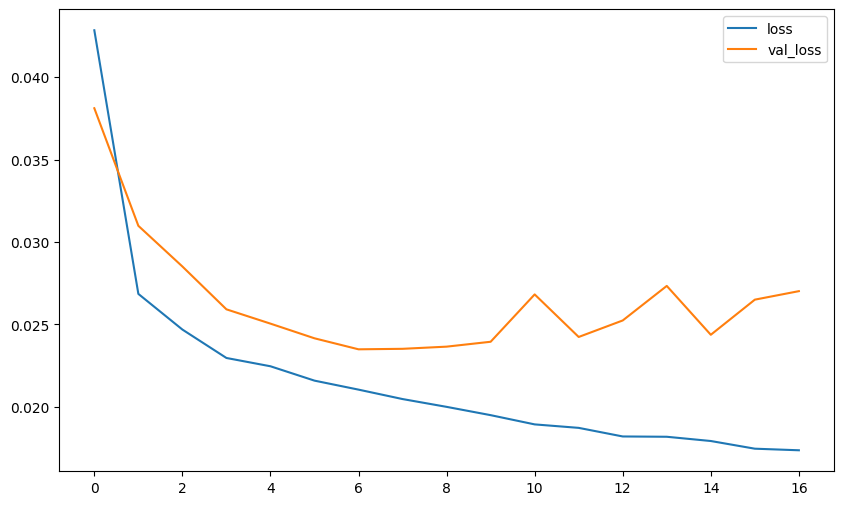

35/35 [==============================] - 1s 13ms/step


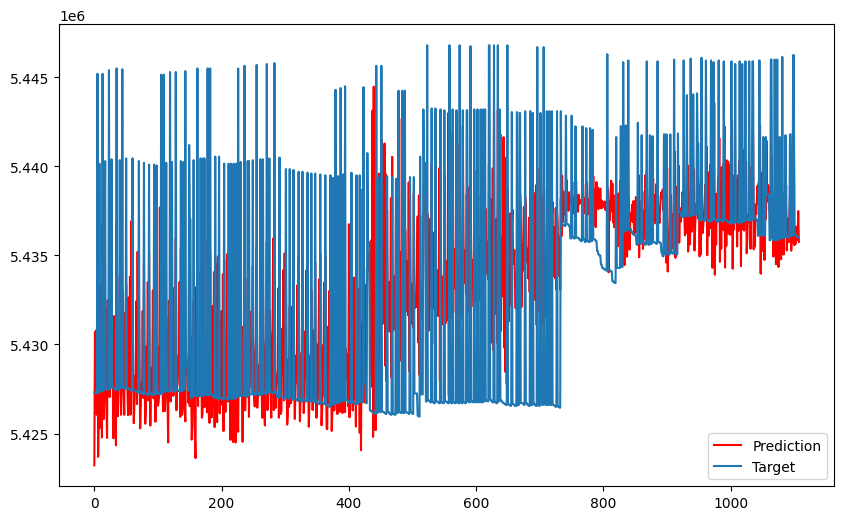

RMSE LSTM: 5391.0292030795645
LSTM with 51 features Regressor Model 6
Epoch 1/100
222/222 [==============================] - 12s 46ms/step - loss: 0.0067 - val_loss: 9.3009e-04
Epoch 2/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0038 - val_loss: 7.7813e-04
Epoch 3/100
222/222 [==============================] - 10s 43ms/step - loss: 0.0014 - val_loss: 7.0325e-04
Epoch 4/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0013 - val_loss: 6.2958e-04
Epoch 5/100
222/222 [==============================] - 10s 43ms/step - loss: 0.0013 - val_loss: 6.5049e-04
Epoch 6/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0014 - val_loss: 6.2528e-04
Epoch 7/100
222/222 [==============================] - 8s 38ms/step - loss: 0.0014 - val_loss: 6.6872e-04
Epoch 8/100
222/222 [==============================] - 10s 46ms/step - loss: 0.0014 - val_loss: 6.3934e-04
Epoch 9/100
222/222 [==============================] - 8s 36ms/step - loss: 0.

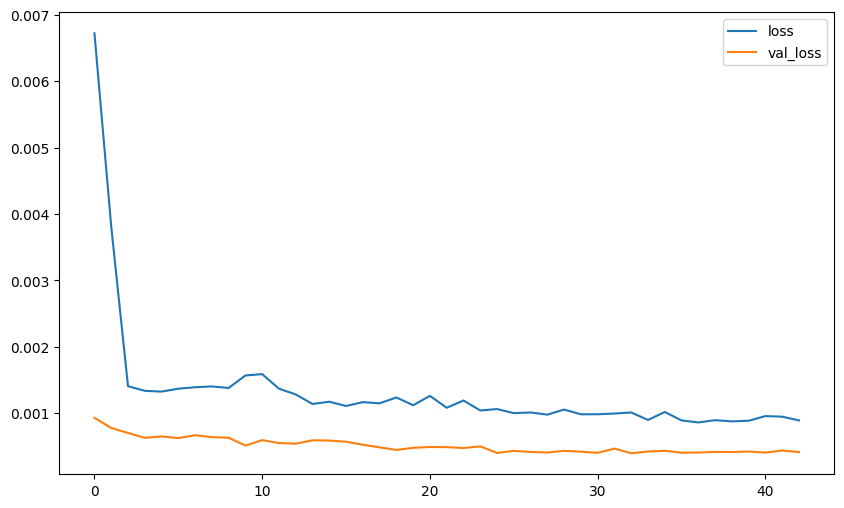

35/35 [==============================] - 1s 13ms/step


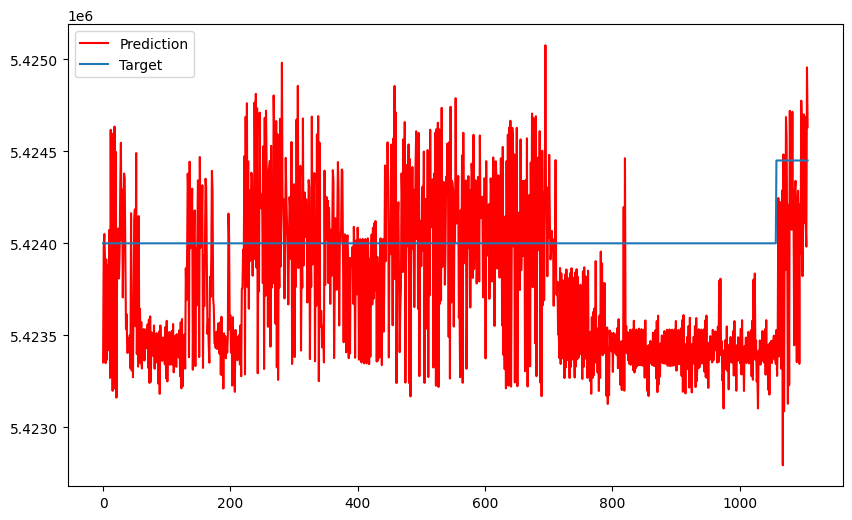

RMSE LSTM: 499.229011397875
LSTM with 51 features Regressor Model 7
Epoch 1/100
222/222 [==============================] - 11s 37ms/step - loss: 0.0123 - val_loss: 0.0566
Epoch 2/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0059 - val_loss: 0.0545
Epoch 3/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0041 - val_loss: 0.0502
Epoch 4/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0035 - val_loss: 0.0496
Epoch 5/100
222/222 [==============================] - 9s 40ms/step - loss: 0.0032 - val_loss: 0.0490
Epoch 6/100
222/222 [==============================] - 9s 38ms/step - loss: 0.0030 - val_loss: 0.0499
Epoch 7/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0029 - val_loss: 0.0514
Epoch 8/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0027 - val_loss: 0.0515
Epoch 9/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0025 - val_loss: 0.0514
Epoch 10/1

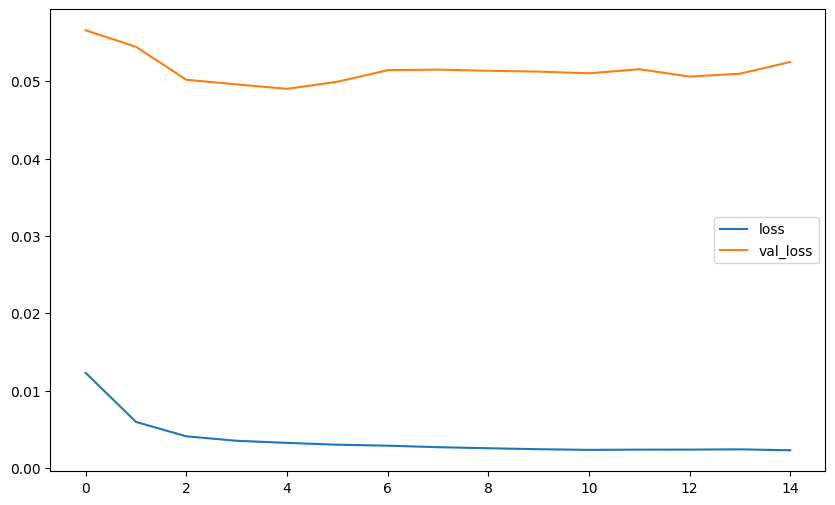

35/35 [==============================] - 1s 13ms/step


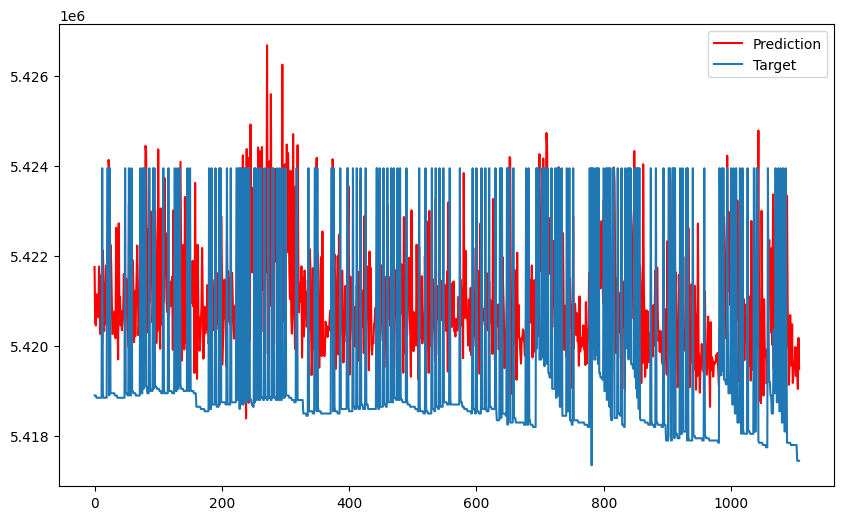

RMSE LSTM: 2607.2141336698573
LSTM with 51 features Regressor Model 8
Epoch 1/100
222/222 [==============================] - 13s 46ms/step - loss: 0.0356 - val_loss: 0.0330
Epoch 2/100
222/222 [==============================] - 8s 37ms/step - loss: 0.0276 - val_loss: 0.0328
Epoch 3/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0257 - val_loss: 0.0323
Epoch 4/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0246 - val_loss: 0.0317
Epoch 5/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0238 - val_loss: 0.0313
Epoch 6/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0232 - val_loss: 0.0311
Epoch 7/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0227 - val_loss: 0.0313
Epoch 8/100
222/222 [==============================] - 10s 43ms/step - loss: 0.0224 - val_loss: 0.0312
Epoch 9/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0222 - val_loss: 0.0318
Epoch 10

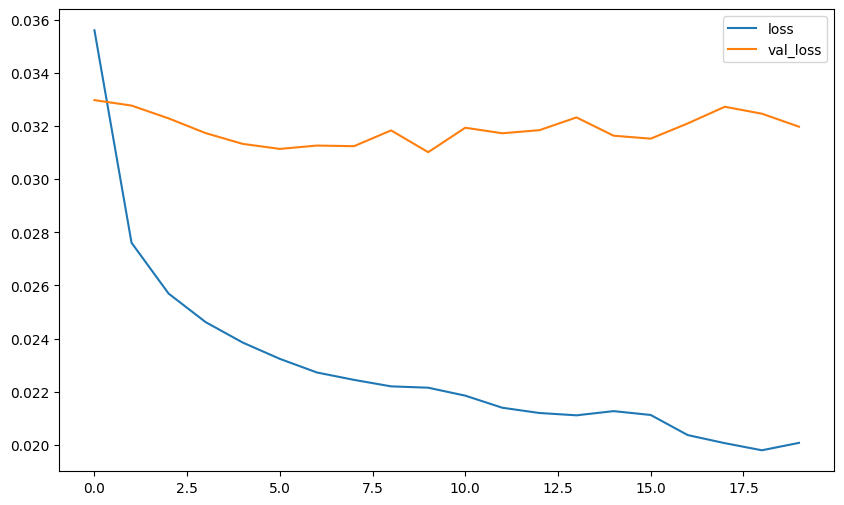

35/35 [==============================] - 1s 13ms/step


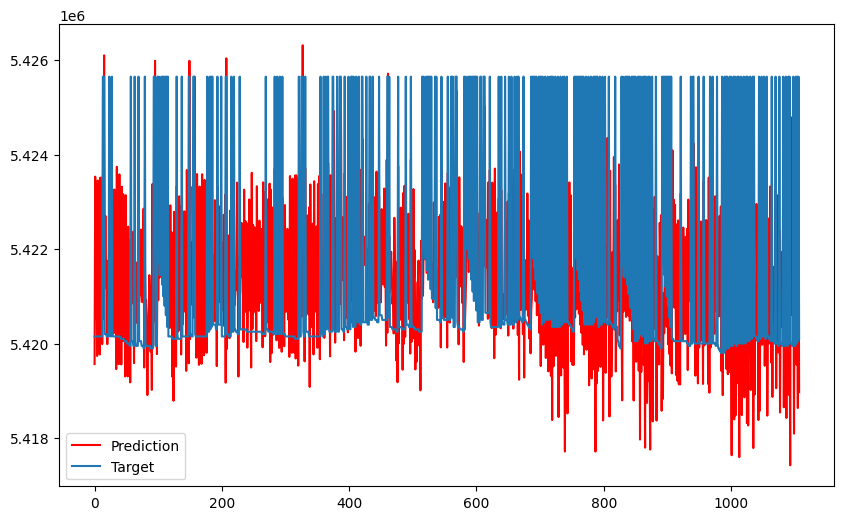

RMSE LSTM: 2067.0231388616
LSTM with 51 features Regressor Model 9
Epoch 1/100
222/222 [==============================] - 13s 46ms/step - loss: 0.0178 - val_loss: 0.0097
Epoch 2/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0154 - val_loss: 0.0081
Epoch 3/100
222/222 [==============================] - 10s 45ms/step - loss: 0.0146 - val_loss: 0.0078
Epoch 4/100
222/222 [==============================] - 8s 37ms/step - loss: 0.0143 - val_loss: 0.0077
Epoch 5/100
222/222 [==============================] - 9s 43ms/step - loss: 0.0142 - val_loss: 0.0077
Epoch 6/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0140 - val_loss: 0.0078
Epoch 7/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0139 - val_loss: 0.0080
Epoch 8/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0139 - val_loss: 0.0081
Epoch 9/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0138 - val_loss: 0.0083
Epoch 10/100

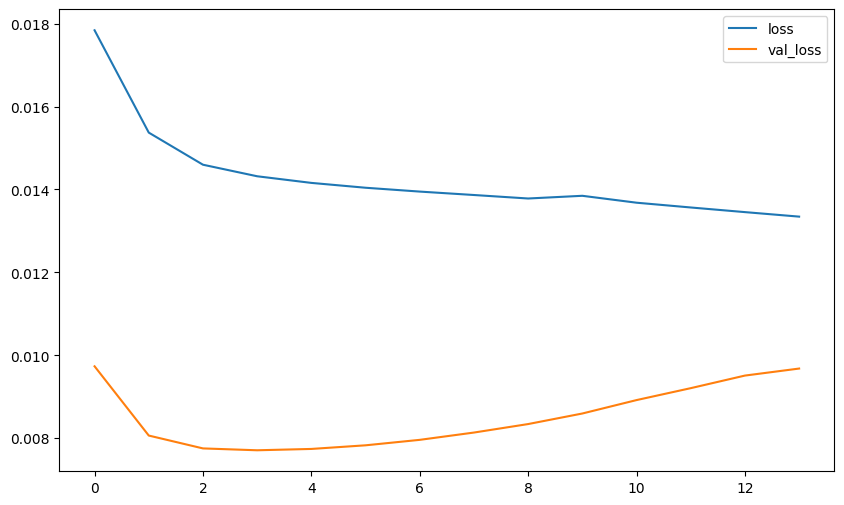

35/35 [==============================] - 1s 13ms/step


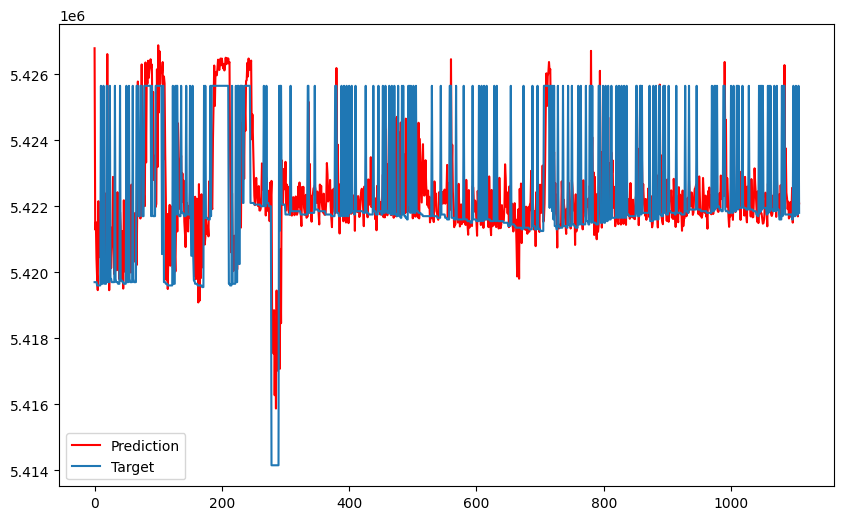

RMSE LSTM: 1687.0476113763184
LSTM with 51 features Regressor Model 10
Epoch 1/100
222/222 [==============================] - 12s 41ms/step - loss: 0.0026 - val_loss: 0.0371
Epoch 2/100
222/222 [==============================] - 10s 45ms/step - loss: 0.0021 - val_loss: 0.0385
Epoch 3/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0021 - val_loss: 0.0374
Epoch 4/100
222/222 [==============================] - 10s 46ms/step - loss: 0.0020 - val_loss: 0.0360
Epoch 5/100
222/222 [==============================] - 8s 38ms/step - loss: 0.0020 - val_loss: 0.0357
Epoch 6/100
222/222 [==============================] - 10s 43ms/step - loss: 0.0020 - val_loss: 0.0348
Epoch 7/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0020 - val_loss: 0.0339
Epoch 8/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0020 - val_loss: 0.0332
Epoch 9/100
222/222 [==============================] - 10s 45ms/step - loss: 0.0020 - val_loss: 0.0328
Epoch 

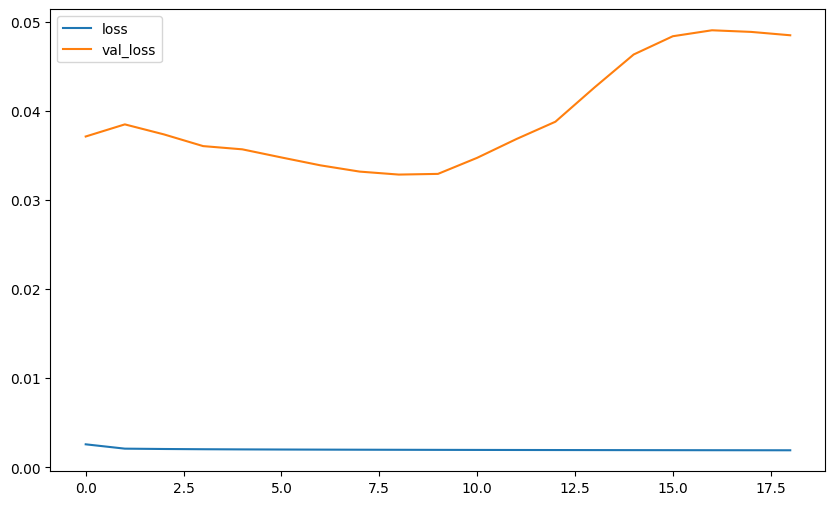

35/35 [==============================] - 1s 14ms/step


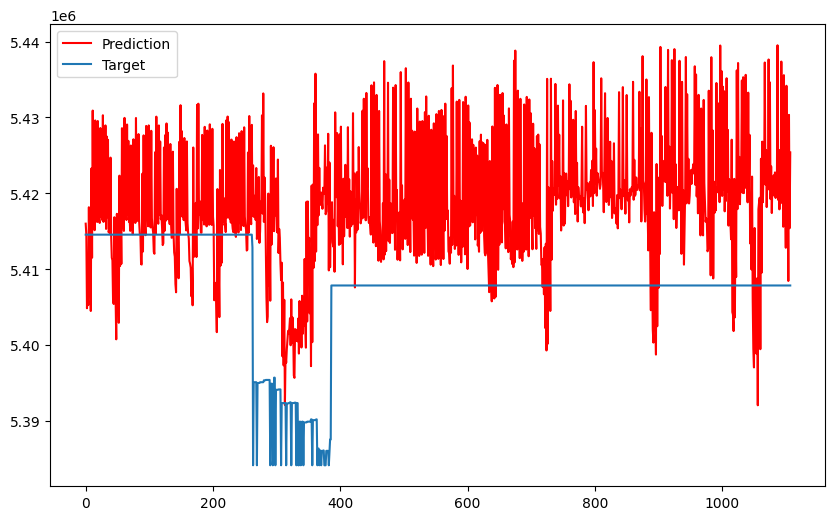

RMSE LSTM: 14648.226317151639


In [71]:
# LSTM AE 60 features + LSTM AE 40 features + MLP + Vanilla LSTM +
# RandomForestRegressor + XGBoost Online Learning

# Define on how many we want to split the data
# We simulate that 100 splits = 100 events to save resource in this assignment
num_splits = 100

# Calculate the size of each split
split_size = len(df_final) // num_splits

# Split the DataFrame into a list of smaller DataFrames
data_splits = [
    df_final.iloc[i * split_size:(i + 1) * split_size] for i in range(num_splits)]

# If there are any remaining data points, add them to the last split
if len(data_splits) % num_splits != 0:
    data_splits[-1] = data_splits[-1].append(
        df_final.iloc[num_splits * split_size:])

# How many data we want to use in this online learning simulation
# E.g. : data_chunk = 10 means 10 out of 100 chunks (10% data)
data_chunk = 10

# Create empty dataframe as a table to save RMSE result
df_results_lstm = pd.DataFrame(
    columns=[
        'Online iteration',
        'LSTM 51 features'])

for i, df_content in enumerate(data_splits):
    if i == data_chunk:
        break

    # Select all column, except the class label (last column)
    df_chunk = df_content.iloc[:, 0:52]
    array_chunk = df_chunk.values

    # Normalise the stock array
    array, scaler = normalise_data(array_chunk)

    # Preparing the data for non-LSTM models (Random Forests, XGBoost, MLP)
    # Use original 40 features+11 handcrafted features for this online learning
    features = array[:, :51]
    label = array[:, -1]
    X, X_test, y, y_test = train_test_split(
        features, label, test_size=0.20, random_state=0, shuffle=False)
    X_train, X_validate, y_train, y_validate = train_test_split(
        X, y, test_size=0.20, random_state=0, shuffle=False)

    # Preparing the data for LSTM model
    look_back = 60  # We use 60 days as the historical data in LSTM
    horizon = 1
    features_array = np.concatenate((features, label.reshape(-1, 1)), axis=1)
    features_lstm, label_lstm = process_lstm_data(
        features_array, look_back, horizon, jump=1)
    X_lstm, X_test_lstm, y_lstm, y_test_lstm = train_test_split(
        features_lstm, label_lstm, test_size=0.20, random_state=0, shuffle=False)
    X_train_lstm, X_validate_lstm, y_train_lstm, y_validate_lstm = train_test_split(
        X_lstm, y_lstm, test_size=0.20, random_state=0, shuffle=False)


    print(f"LSTM with 51 features Regressor Model {i+1}")
    rmse_model = lstm(
        X_train_lstm,
        X_validate_lstm,
        X_test_lstm,
        y_train_lstm,
        y_validate_lstm,
        y_test_lstm,
        i)

    df_results_lstm = pd.concat([df_results_lstm,
                            pd.DataFrame({'Online iteration': [i + 1],
                                          'LSTM 51 features': [rmse_model]})],
                           ignore_index=True)

# Save the RMSE result to CVS in Google Drive
df_results_lstm.to_csv(
    '/drive/My Drive/Colab Notebooks/FML 2/result_lstm_51.csv',
    index=True)


In [86]:
# Printing the result

df_results_lstm

# This result shows that 11 handcrafted features slightly improved
# the vanilla LSTM chosen from previous online learning

Online iteration  LSTM 51 features
0                1       6289.685838
1                2       5412.297879
2                3      49965.176509
3                4      11721.471020
4                5       5391.029203
5                6        499.229011
6                7       2607.214134
7                8       2067.023139
8                9       1687.047611
9               10      14648.226317